In [1]:
import traceback

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib


#from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
def get_data():
    dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
    ldata_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
    ldata_dir = pathlib.Path(ldata_dir)

    return ldata_dir

In [3]:
def save_model(model):
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)

    model.save_weights("model.h5")
    print("Saved model to disk")


def retrieve_model():
    print('retrieving model')

    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("model.h5")
    print("Loaded model from disk")

    return loaded_model

In [4]:
data_dir = get_data()
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [5]:
img_height = 180
img_width = 180
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
class_names = train_ds.class_names

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [6]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

'''for better performance'''
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

2021-12-28 19:53:59.957477: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-28 19:53:59.959712: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


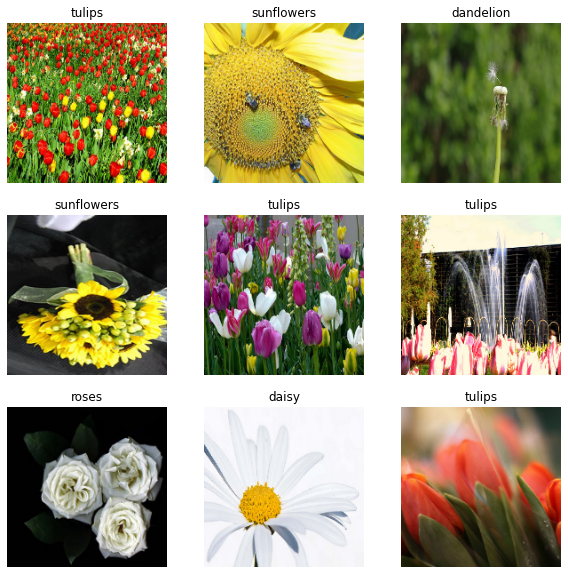

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
num_classes = len(class_names)
from tensorflow.python.keras.callbacks import TensorBoard 
from datetime import date

In [9]:
def generate_model(gene):
    print('create model for ' + str(gene))
    model = Sequential()
    model.add(data_augmentation)
    model.add(layers.Rescaling(1./255, input_shape=(180,180,3)))
    for i in range (gene[0]):
        model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
        if gene[i+1] == 1:
            model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes))
    
    model.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    # model.summary()
    return model

In [10]:
''' train '''
def train(model, epochs, nmb_of_generation, gene):
    # log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    today = date.today()

    # dd/mm/YY
    d1 = today.strftime("%d-%m-%Y")
    # tensorboard = TensorBoard(log_dir=)
    
    log = "logs/" + str(d1) +"_var3" + "/"+ str(nmb_of_generation) + "/" + str(gene)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log, histogram_freq=1)
    # loss_history = LossHistory()
    try:
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            verbose=1,
            callbacks=[tensorboard_callback]
        )
    except tf.errors.ResourceExhaustedError as e:
        print('\n ResourceExhausted Error: Cannot allocate enough memory')
        return -1
    return history.history['val_accuracy']

In [11]:
def generate_initial_generation(nmb_indiv):
    arr = []
    for i in range(nmb_indiv):
        while True:
            nmb_layers = np.array([np.random.randint(2,6)])
            gene = np.random.randint(2,size=nmb_layers)
            poz_for_maxpooling = np.random.randint(0,nmb_layers)
            gene[poz_for_maxpooling] = 1
            gene = np.concatenate((nmb_layers, gene), axis=0)
            
            ok = True
            for el in arr:
                if np.array_equal(el, gene):
                    ok = False
            if ok:
                break
            
        arr.append(gene)
    arr = np.asarray(arr)
    print('Individuals:')
    print(arr)
    return arr

In [12]:

generate_initial_generation(11)

Individuals:
[array([2, 1, 1]) array([4, 1, 1, 1, 0]) array([2, 0, 1])
 array([3, 0, 1, 1]) array([5, 1, 0, 1, 1, 1]) array([5, 0, 1, 1, 0, 1])
 array([5, 1, 0, 0, 0, 1]) array([4, 1, 0, 1, 0]) array([3, 0, 0, 1])
 array([4, 0, 0, 1, 0]) array([4, 1, 1, 0, 0])]


C:\Users\sorana\AppData\Local\Temp/ipykernel_4408/2135233446.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asarray(arr)


array([array([2, 1, 1]), array([4, 1, 1, 1, 0]), array([2, 0, 1]),
       array([3, 0, 1, 1]), array([5, 1, 0, 1, 1, 1]),
       array([5, 0, 1, 1, 0, 1]), array([5, 1, 0, 0, 0, 1]),
       array([4, 1, 0, 1, 0]), array([3, 0, 0, 1]),
       array([4, 0, 0, 1, 0]), array([4, 1, 1, 0, 0])], dtype=object)

In [12]:
import random


def mutation(mutation_rate, offspring, debug):
    mutation_point = random.randint(0, offspring[0])
    if debug:
        print('mutation')
        print(offspring)
        print(mutation_point)
    is_mutated = random.randint(1, 100)
    if is_mutated < mutation_rate*100:
        if mutation_point != 0:
            offspring[mutation_point] = 1 - offspring[mutation_point]
        else:
            if offspring[0] == 2:
                rand = 1
            elif offspring[0] == 5:
                rand = 0
            else:
                rand = random.randint(0, 1)
                
            if rand==0:
                offspring = offspring[:-1]
                offspring[0] = offspring[0] - 1
            else:
                addon = random.randint(0, 1)
                offspring = np.append(offspring, addon)
                offspring[0] = offspring[0] + 1 
    return offspring
    

def create_offspring(parent1, parent2, crossover_point, debug):
    offspring = []
    if debug:
        print('offspring:')
        print(parent1)
        print(parent2)
        print(crossover_point)
    offspring.append(parent1[0])
    if crossover_point != parent1[0]:
        offspring = np.append(offspring, parent2[1:(crossover_point+1)])
        offspring = np.append(offspring, parent1[(crossover_point+1):])
    else:
        offspring = np.append(offspring, parent2[1:(crossover_point+1)])

    return offspring


def update_generation(population, fitness, nmb_ind, mutation_rate, debug):
    # code cleanup, mutatia, prima antrenare  
    new_population = []
    pop=[]
    for idx, el in enumerate(population):
        pop.append([el, fitness[idx]])
        
    for i in range(int(nmb_ind/2)):
        parents = random.sample(pop, k=4)
        parents = sorted(parents, key=lambda agent: agent[1], reverse=True)
        crossover_point = random.randint(0, min(parents[0][0][0], parents[1][0][0]))
        
        par1 = parents[0][0]
        par2 = parents[1][0]
        
        check_dupl = 0
        while True:
            off1 = create_offspring(par1, par2, crossover_point, debug)
            ok = True
            for el in new_population:
                if np.array_equal(el, off1):
                    ok = False
            if ok==True:
                break
            check_dupl = check_dupl + 1
            if check_dupl > 3:
                break
        new_population.append(mutation(mutation_rate, off1, debug))
        
        check_dupl = 0
        while True:
            off2 = create_offspring(par2, par1, crossover_point, debug)
            ok = True
            for el in new_population:
                if np.array_equal(el, off2):
                    ok = False
            if ok==True:
                break
            check_dupl = check_dupl + 1
            if check_dupl > 3:
                break
        new_population.append(mutation(mutation_rate, off2, debug))
        
    new_population = np.asarray(new_population)
    print(new_population)
    return new_population

In [29]:
pop = np.array([[2, 0, 0],
               [2, 1, 1],
               [2, 0, 0],
               [2, 1, 1]
                ])

fit = np.array([2, 6, 6, 6])
print(update_generation(pop, fit, 2, 0.25, True))

offspring:
[2 1 1]
[2 0 0]
1
mutation
[2 0 1]
2
offspring:
[2 0 0]
[2 1 1]
1
mutation
[2 1 0]
0
[[2 0 1]
 [2 1 0]]
[[2 0 1]
 [2 1 0]]


In [13]:
def train_by_GA(nmb_of_generations, nmb_ind_per_gen, nmb_of_epochs, mutation_rate, debug):
    population = np.array(generate_initial_generation(nmb_ind_per_gen))
    input('Press Enter to continue...')
    fitness = np.zeros(nmb_ind_per_gen)
    for gen in range(nmb_of_generations):
        print('generation: ' + str(gen))
        for idx_ind, gene in enumerate(population):
            print('individual' + str(idx_ind) + ":" + str(gene))
            model = generate_model(gene)
            hist = train(model, nmb_of_epochs, gen+1, gene)
            if hist == -1:
                fitness[idx_ind] = -1
            else:
                fitness[idx_ind] = hist[nmb_of_epochs-1]
        population = update_generation(population, fitness,  nmb_ind_per_gen, mutation_rate,debug)
        print('Updated population:')
        print(population)
        


In [ ]:
train_by_GA(nmb_of_generations=5, nmb_ind_per_gen=12, nmb_of_epochs=10, mutation_rate=0.2, debug=False)

Individuals:
[array([2, 1, 1]) array([5, 1, 0, 0, 0, 1]) array([3, 1, 1, 0])
 array([3, 0, 1, 0]) array([5, 0, 1, 0, 1, 0]) array([2, 0, 1])
 array([3, 1, 1, 1]) array([4, 1, 0, 1, 1]) array([4, 1, 1, 1, 0])
 array([5, 1, 1, 1, 0, 1]) array([4, 1, 1, 0, 0]) array([4, 1, 1, 1, 1])]


Press Enter to continue... 


generation: 0
individual0:[2 1 1]
create model for [2 1 1]


2021-12-28 19:55:55.669400: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-28 19:55:55.669420: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-28 19:55:55.670419: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/10
 1/92 [..............................] - ETA: 1:51 - loss: 1.6096 - accuracy: 0.2188

2021-12-28 19:55:56.950965: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-28 19:55:56.950990: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 50s - loss: 6.8331 - accuracy: 0.1562 

2021-12-28 19:55:57.493050: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-28 19:55:57.514352: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-28 19:55:57.534771: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/28-12-2021_var3/1/[2 1 1]/train/plugins/profile/2021_12_28_19_55_57

2021-12-28 19:55:57.536716: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/28-12-2021_var3/1/[2 1 1]/train/plugins/profile/2021_12_28_19_55_57/Andreis-Air.trace.json.gz
2021-12-28 19:55:57.556883: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/28-12-2021_var3/1/[2 1 1]/train/plugins/profile/2021_12_28_19_55_57

2021-12-28 19:55:57.557164: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/28-12-2021_var3/1/[2 1 1]/trai

92/92 [==============================] - 52s 555ms/step - loss: 1.6078 - accuracy: 0.3518 - val_loss: 1.2272 - val_accuracy: 0.4823
Epoch 2/10
92/92 [==============================] - 49s 536ms/step - loss: 1.1787 - accuracy: 0.5184 - val_loss: 1.0501 - val_accuracy: 0.5831
Epoch 3/10
92/92 [==============================] - 50s 546ms/step - loss: 1.0727 - accuracy: 0.5913 - val_loss: 0.9774 - val_accuracy: 0.6090
Epoch 4/10
92/92 [==============================] - 47s 509ms/step - loss: 0.9620 - accuracy: 0.6240 - val_loss: 1.0707 - val_accuracy: 0.5886
Epoch 5/10
92/92 [==============================] - 47s 516ms/step - loss: 0.8959 - accuracy: 0.6601 - val_loss: 0.8854 - val_accuracy: 0.6485
Epoch 6/10
92/92 [==============================] - 52s 563ms/step - loss: 0.8437 - accuracy: 0.6614 - val_loss: 1.0298 - val_accuracy: 0.6022
Epoch 7/10
92/92 [==============================] - 53s 578ms/step - loss: 0.8026 - accuracy: 0.6958 - val_loss: 0.8098 - val_accuracy: 0.6866
Epoch 8/10

2021-12-28 20:04:42.270232: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-28 20:04:42.270259: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-28 20:04:42.270414: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/10
 1/92 [..............................] - ETA: 2:47 - loss: 1.6093 - accuracy: 0.1250

2021-12-28 20:04:44.181771: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-28 20:04:44.181814: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 1:44 - loss: 4.4372 - accuracy: 0.1719

2021-12-28 20:04:45.333491: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-28 20:04:45.335916: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-28 20:04:45.339711: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/28-12-2021_var3/1/[5 1 0 0 0 1]/train/plugins/profile/2021_12_28_20_04_45

2021-12-28 20:04:45.341763: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/28-12-2021_var3/1/[5 1 0 0 0 1]/train/plugins/profile/2021_12_28_20_04_45/Andreis-Air.trace.json.gz
2021-12-28 20:04:45.345827: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/28-12-2021_var3/1/[5 1 0 0 0 1]/train/plugins/profile/2021_12_28_20_04_45

2021-12-28 20:04:45.346109: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/28-12-2021_v

92/92 [==============================] - 116s 1s/step - loss: 1.4939 - accuracy: 0.3842 - val_loss: 1.2009 - val_accuracy: 0.5054
Epoch 2/10
92/92 [==============================] - 105s 1s/step - loss: 1.1803 - accuracy: 0.4952 - val_loss: 1.1717 - val_accuracy: 0.5313
Epoch 3/10
92/92 [==============================] - 114s 1s/step - loss: 1.0964 - accuracy: 0.5705 - val_loss: 0.9920 - val_accuracy: 0.5926
Epoch 4/10
92/92 [==============================] - 106s 1s/step - loss: 1.0047 - accuracy: 0.6049 - val_loss: 0.9757 - val_accuracy: 0.6022
Epoch 5/10
92/92 [==============================] - 112s 1s/step - loss: 0.9331 - accuracy: 0.6356 - val_loss: 0.9721 - val_accuracy: 0.6213
Epoch 6/10
92/92 [==============================] - 105s 1s/step - loss: 0.8862 - accuracy: 0.6608 - val_loss: 0.9646 - val_accuracy: 0.6213
Epoch 7/10
92/92 [==============================] - 124s 1s/step - loss: 0.8617 - accuracy: 0.6662 - val_loss: 0.8621 - val_accuracy: 0.6553
Epoch 8/10
92/92 [======

2021-12-28 20:23:59.115617: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-28 20:23:59.115634: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-28 20:23:59.116435: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 1:41 - loss: 1.6178 - accuracy: 0.1562

2021-12-28 20:24:00.265116: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-28 20:24:00.265137: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 51s - loss: 3.0026 - accuracy: 0.2031 

2021-12-28 20:24:00.844112: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-28 20:24:00.845521: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-28 20:24:00.847210: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/28-12-2021_var3/1/[3 1 1 0]/train/plugins/profile/2021_12_28_20_24_00

2021-12-28 20:24:00.849517: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/28-12-2021_var3/1/[3 1 1 0]/train/plugins/profile/2021_12_28_20_24_00/Andreis-Air.trace.json.gz
2021-12-28 20:24:00.853153: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/28-12-2021_var3/1/[3 1 1 0]/train/plugins/profile/2021_12_28_20_24_00

2021-12-28 20:24:00.853378: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/28-12-2021_var3/1/[3 1 1

92/92 [==============================] - 56s 608ms/step - loss: 1.4325 - accuracy: 0.4189 - val_loss: 1.1367 - val_accuracy: 0.5654
Epoch 2/10
92/92 [==============================] - 53s 580ms/step - loss: 1.0969 - accuracy: 0.5572 - val_loss: 1.0417 - val_accuracy: 0.6076
Epoch 3/10
92/92 [==============================] - 55s 602ms/step - loss: 1.0074 - accuracy: 0.6223 - val_loss: 1.0278 - val_accuracy: 0.6131
Epoch 4/10
92/92 [==============================] - 1025s 11s/step - loss: 0.9188 - accuracy: 0.6441 - val_loss: 0.9730 - val_accuracy: 0.6417
Epoch 5/10
92/92 [==============================] - 952s 10s/step - loss: 0.8858 - accuracy: 0.6614 - val_loss: 0.8865 - val_accuracy: 0.6485
Epoch 6/10
92/92 [==============================] - 1020s 11s/step - loss: 0.8241 - accuracy: 0.6826 - val_loss: 0.8628 - val_accuracy: 0.6649
Epoch 7/10
92/92 [==============================] - 949s 10s/step - loss: 0.7796 - accuracy: 0.6911 - val_loss: 0.8721 - val_accuracy: 0.6553
Epoch 8/10
9

2021-12-28 22:24:09.906158: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-28 22:24:09.906170: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-28 22:24:09.906418: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 2:01 - loss: 1.6001 - accuracy: 0.2188

2021-12-28 22:24:11.263710: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-28 22:24:11.263729: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 1:23 - loss: 12.7024 - accuracy: 0.1250

2021-12-28 22:24:12.200184: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-28 22:24:12.201811: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-28 22:24:12.204899: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/28-12-2021_var3/1/[3 0 1 0]/train/plugins/profile/2021_12_28_22_24_12

2021-12-28 22:24:12.205815: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/28-12-2021_var3/1/[3 0 1 0]/train/plugins/profile/2021_12_28_22_24_12/Andreis-Air.trace.json.gz
2021-12-28 22:24:12.207735: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/28-12-2021_var3/1/[3 0 1 0]/train/plugins/profile/2021_12_28_22_24_12

2021-12-28 22:24:12.207954: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/28-12-2021_var3/1/[3 0 1

92/92 [==============================] - 975s 11s/step - loss: 1.8978 - accuracy: 0.4053 - val_loss: 1.2210 - val_accuracy: 0.5000
Epoch 2/10
92/92 [==============================] - 111s 1s/step - loss: 1.1549 - accuracy: 0.5361 - val_loss: 1.1153 - val_accuracy: 0.5681
Epoch 3/10
92/92 [==============================] - 113s 1s/step - loss: 1.0421 - accuracy: 0.6001 - val_loss: 1.0592 - val_accuracy: 0.5613
Epoch 4/10
92/92 [==============================] - 113s 1s/step - loss: 1.0119 - accuracy: 0.6015 - val_loss: 1.0379 - val_accuracy: 0.5913
Epoch 5/10
92/92 [==============================] - 110s 1s/step - loss: 0.9579 - accuracy: 0.6247 - val_loss: 0.9370 - val_accuracy: 0.6240
Epoch 6/10
92/92 [==============================] - 118s 1s/step - loss: 0.8950 - accuracy: 0.6499 - val_loss: 0.9094 - val_accuracy: 0.6499
Epoch 7/10
92/92 [==============================] - 113s 1s/step - loss: 0.8753 - accuracy: 0.6652 - val_loss: 0.8982 - val_accuracy: 0.6608
Epoch 8/10
92/92 [=====

2021-12-28 22:59:15.679474: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-28 22:59:15.679489: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-28 22:59:15.680539: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/10
 1/92 [..............................] - ETA: 3:57 - loss: 1.6116 - accuracy: 0.2812

2021-12-28 22:59:18.330476: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-28 22:59:18.330496: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 2:19 - loss: 1.6363 - accuracy: 0.2500

2021-12-28 22:59:19.894076: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-28 22:59:19.927540: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-28 22:59:19.952984: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/28-12-2021_var3/1/[5 0 1 0 1 0]/train/plugins/profile/2021_12_28_22_59_19

2021-12-28 22:59:19.955671: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/28-12-2021_var3/1/[5 0 1 0 1 0]/train/plugins/profile/2021_12_28_22_59_19/Andreis-Air.trace.json.gz
2021-12-28 22:59:19.985474: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/28-12-2021_var3/1/[5 0 1 0 1 0]/train/plugins/profile/2021_12_28_22_59_19

2021-12-28 22:59:19.985740: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/28-12-2021_v

92/92 [==============================] - 140s 2s/step - loss: 1.3761 - accuracy: 0.3794 - val_loss: 1.1942 - val_accuracy: 0.4850
Epoch 2/10
92/92 [==============================] - 137s 1s/step - loss: 1.1567 - accuracy: 0.5092 - val_loss: 1.1128 - val_accuracy: 0.5409
Epoch 3/10
92/92 [==============================] - 136s 1s/step - loss: 1.0389 - accuracy: 0.5892 - val_loss: 0.9759 - val_accuracy: 0.6226
Epoch 4/10
92/92 [==============================] - 134s 1s/step - loss: 0.9810 - accuracy: 0.6178 - val_loss: 0.8826 - val_accuracy: 0.6635
Epoch 5/10
92/92 [==============================] - 1045s 11s/step - loss: 0.8851 - accuracy: 0.6611 - val_loss: 0.8872 - val_accuracy: 0.6376
Epoch 6/10
92/92 [==============================] - 1969s 22s/step - loss: 0.8446 - accuracy: 0.6730 - val_loss: 0.8463 - val_accuracy: 0.6621
Epoch 7/10
92/92 [==============================] - 1960s 22s/step - loss: 0.8060 - accuracy: 0.6938 - val_loss: 0.8407 - val_accuracy: 0.6866
Epoch 8/10
92/92 [

2021-12-29 02:10:25.503812: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 02:10:25.503823: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 02:10:25.503877: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 1:51 - loss: 1.6162 - accuracy: 0.2500

2021-12-29 02:10:26.761802: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 02:10:26.761831: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 1:10 - loss: 13.9122 - accuracy: 0.2812

2021-12-29 02:10:27.554102: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 02:10:27.556771: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 02:10:27.558159: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/1/[2 0 1]/train/plugins/profile/2021_12_29_02_10_27

2021-12-29 02:10:27.559601: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/1/[2 0 1]/train/plugins/profile/2021_12_29_02_10_27/Andreis-Air.trace.json.gz
2021-12-29 02:10:27.562107: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/1/[2 0 1]/train/plugins/profile/2021_12_29_02_10_27

2021-12-29 02:10:27.562262: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/1/[2 0 1]/trai

92/92 [==============================] - 1260s 14s/step - loss: 2.6093 - accuracy: 0.3590 - val_loss: 1.1884 - val_accuracy: 0.5341
Epoch 2/10
92/92 [==============================] - 99s 1s/step - loss: 1.1117 - accuracy: 0.5535 - val_loss: 1.0720 - val_accuracy: 0.5886
Epoch 3/10
92/92 [==============================] - 113s 1s/step - loss: 1.0126 - accuracy: 0.6076 - val_loss: 1.0178 - val_accuracy: 0.5926
Epoch 4/10
92/92 [==============================] - 117s 1s/step - loss: 0.9270 - accuracy: 0.6352 - val_loss: 1.0281 - val_accuracy: 0.6308
Epoch 5/10
92/92 [==============================] - 137s 1s/step - loss: 0.8616 - accuracy: 0.6775 - val_loss: 0.8880 - val_accuracy: 0.6649
Epoch 6/10
92/92 [==============================] - 154s 2s/step - loss: 0.8330 - accuracy: 0.6795 - val_loss: 0.9084 - val_accuracy: 0.6240
Epoch 7/10
92/92 [==============================] - 116s 1s/step - loss: 0.7822 - accuracy: 0.6975 - val_loss: 0.9028 - val_accuracy: 0.6608
Epoch 8/10
92/92 [=====

2021-12-29 02:51:34.377408: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 02:51:34.377425: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 02:51:34.377549: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 1:46 - loss: 1.6159 - accuracy: 0.2500

2021-12-29 02:51:35.595022: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 02:51:35.595045: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 55s - loss: 1.7494 - accuracy: 0.2812 

2021-12-29 02:51:36.250285: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 02:51:36.252359: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 02:51:36.255149: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/1/[3 1 1 1]/train/plugins/profile/2021_12_29_02_51_36

2021-12-29 02:51:36.257309: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/1/[3 1 1 1]/train/plugins/profile/2021_12_29_02_51_36/Andreis-Air.trace.json.gz
2021-12-29 02:51:36.271622: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/1/[3 1 1 1]/train/plugins/profile/2021_12_29_02_51_36

2021-12-29 02:51:36.271944: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/1/[3 1 1

92/92 [==============================] - 53s 569ms/step - loss: 1.3414 - accuracy: 0.4128 - val_loss: 1.1724 - val_accuracy: 0.5286
Epoch 2/10
92/92 [==============================] - 52s 564ms/step - loss: 1.1190 - accuracy: 0.5436 - val_loss: 1.0687 - val_accuracy: 0.5790
Epoch 3/10
92/92 [==============================] - 50s 547ms/step - loss: 1.0259 - accuracy: 0.5899 - val_loss: 0.9620 - val_accuracy: 0.6131
Epoch 4/10
92/92 [==============================] - 50s 545ms/step - loss: 0.9323 - accuracy: 0.6393 - val_loss: 0.9356 - val_accuracy: 0.6431
Epoch 5/10
92/92 [==============================] - 50s 540ms/step - loss: 0.8818 - accuracy: 0.6686 - val_loss: 0.9185 - val_accuracy: 0.6349
Epoch 6/10
92/92 [==============================] - 50s 546ms/step - loss: 0.8252 - accuracy: 0.6819 - val_loss: 0.8475 - val_accuracy: 0.6635
Epoch 7/10
92/92 [==============================] - 52s 570ms/step - loss: 0.7902 - accuracy: 0.6935 - val_loss: 0.8264 - val_accuracy: 0.6771
Epoch 8/10

2021-12-29 03:00:06.627967: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 03:00:06.627985: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 03:00:06.628474: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 2:02 - loss: 1.6020 - accuracy: 0.3438

2021-12-29 03:00:08.011192: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 03:00:08.011217: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 1:05 - loss: 1.7012 - accuracy: 0.3281

2021-12-29 03:00:08.748372: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 03:00:08.750506: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 03:00:08.753473: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/1/[4 1 0 1 1]/train/plugins/profile/2021_12_29_03_00_08

2021-12-29 03:00:08.756082: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/1/[4 1 0 1 1]/train/plugins/profile/2021_12_29_03_00_08/Andreis-Air.trace.json.gz
2021-12-29 03:00:08.759344: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/1/[4 1 0 1 1]/train/plugins/profile/2021_12_29_03_00_08

2021-12-29 03:00:08.759620: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/1/

92/92 [==============================] - 70s 749ms/step - loss: 1.2682 - accuracy: 0.4469 - val_loss: 1.0867 - val_accuracy: 0.5477
Epoch 2/10
92/92 [==============================] - 68s 737ms/step - loss: 1.0410 - accuracy: 0.5882 - val_loss: 1.1489 - val_accuracy: 0.5381
Epoch 3/10
92/92 [==============================] - 68s 741ms/step - loss: 0.9603 - accuracy: 0.6281 - val_loss: 0.8925 - val_accuracy: 0.6567
Epoch 4/10
92/92 [==============================] - 70s 761ms/step - loss: 0.8756 - accuracy: 0.6631 - val_loss: 0.8631 - val_accuracy: 0.6662
Epoch 5/10
92/92 [==============================] - 68s 740ms/step - loss: 0.8283 - accuracy: 0.6860 - val_loss: 0.8456 - val_accuracy: 0.6689
Epoch 6/10
92/92 [==============================] - 68s 743ms/step - loss: 0.7787 - accuracy: 0.7037 - val_loss: 0.8570 - val_accuracy: 0.6812
Epoch 7/10
92/92 [==============================] - 67s 727ms/step - loss: 0.7576 - accuracy: 0.7190 - val_loss: 0.7599 - val_accuracy: 0.7003
Epoch 8/10

2021-12-29 03:11:24.074406: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 03:11:24.074423: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 03:11:24.074490: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 1:53 - loss: 1.6018 - accuracy: 0.2812

2021-12-29 03:11:25.354383: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 03:11:25.354399: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 50s - loss: 1.6014 - accuracy: 0.2500 

2021-12-29 03:11:25.926489: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 03:11:25.928805: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 03:11:25.937229: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/1/[4 1 1 1 0]/train/plugins/profile/2021_12_29_03_11_25

2021-12-29 03:11:25.944733: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/1/[4 1 1 1 0]/train/plugins/profile/2021_12_29_03_11_25/Andreis-Air.trace.json.gz
2021-12-29 03:11:25.947744: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/1/[4 1 1 1 0]/train/plugins/profile/2021_12_29_03_11_25

2021-12-29 03:11:25.948030: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/1/

92/92 [==============================] - 51s 542ms/step - loss: 1.3010 - accuracy: 0.4234 - val_loss: 1.1665 - val_accuracy: 0.4905
Epoch 2/10
92/92 [==============================] - 50s 545ms/step - loss: 1.0686 - accuracy: 0.5630 - val_loss: 1.0883 - val_accuracy: 0.5572
Epoch 3/10
92/92 [==============================] - 49s 532ms/step - loss: 0.9674 - accuracy: 0.6155 - val_loss: 0.9142 - val_accuracy: 0.6431
Epoch 4/10
92/92 [==============================] - 50s 541ms/step - loss: 0.8817 - accuracy: 0.6649 - val_loss: 0.8717 - val_accuracy: 0.6567
Epoch 5/10
92/92 [==============================] - 49s 531ms/step - loss: 0.8387 - accuracy: 0.6734 - val_loss: 0.8015 - val_accuracy: 0.6812
Epoch 6/10
92/92 [==============================] - 49s 535ms/step - loss: 0.8075 - accuracy: 0.6880 - val_loss: 0.7917 - val_accuracy: 0.6935
Epoch 7/10
92/92 [==============================] - 49s 529ms/step - loss: 0.7615 - accuracy: 0.7003 - val_loss: 0.7958 - val_accuracy: 0.6853
Epoch 8/10

2021-12-29 03:19:41.155275: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 03:19:41.155299: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 03:19:41.155474: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 2:10 - loss: 1.6071 - accuracy: 0.2188

2021-12-29 03:19:42.628902: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 03:19:42.628923: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 47s - loss: 1.6091 - accuracy: 0.2344 

2021-12-29 03:19:43.166456: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 03:19:43.168563: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 03:19:43.170943: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/1/[5 1 1 1 0 1]/train/plugins/profile/2021_12_29_03_19_43

2021-12-29 03:19:43.173491: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/1/[5 1 1 1 0 1]/train/plugins/profile/2021_12_29_03_19_43/Andreis-Air.trace.json.gz
2021-12-29 03:19:43.176808: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/1/[5 1 1 1 0 1]/train/plugins/profile/2021_12_29_03_19_43

2021-12-29 03:19:43.177032: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_v

92/92 [==============================] - 52s 551ms/step - loss: 1.2740 - accuracy: 0.4329 - val_loss: 1.0992 - val_accuracy: 0.5490
Epoch 2/10
92/92 [==============================] - 51s 551ms/step - loss: 1.0772 - accuracy: 0.5838 - val_loss: 1.1347 - val_accuracy: 0.5777
Epoch 3/10
92/92 [==============================] - 51s 552ms/step - loss: 0.9347 - accuracy: 0.6427 - val_loss: 1.1610 - val_accuracy: 0.5627
Epoch 4/10
92/92 [==============================] - 50s 549ms/step - loss: 0.8853 - accuracy: 0.6577 - val_loss: 0.8732 - val_accuracy: 0.6676
Epoch 5/10
92/92 [==============================] - 50s 547ms/step - loss: 0.8221 - accuracy: 0.6853 - val_loss: 0.8576 - val_accuracy: 0.6676
Epoch 6/10
92/92 [==============================] - 50s 549ms/step - loss: 0.7789 - accuracy: 0.6962 - val_loss: 0.8921 - val_accuracy: 0.6608
Epoch 7/10
92/92 [==============================] - 51s 560ms/step - loss: 0.7657 - accuracy: 0.7129 - val_loss: 0.7876 - val_accuracy: 0.7071
Epoch 8/10

2021-12-29 03:28:12.484118: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 03:28:12.484133: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 03:28:12.484312: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 1:47 - loss: 1.6231 - accuracy: 0.1250

2021-12-29 03:28:13.699329: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 03:28:13.699347: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 52s - loss: 1.7041 - accuracy: 0.1562 

2021-12-29 03:28:14.293781: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 03:28:14.295320: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 03:28:14.297938: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/1/[4 1 1 0 0]/train/plugins/profile/2021_12_29_03_28_14

2021-12-29 03:28:14.300170: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/1/[4 1 1 0 0]/train/plugins/profile/2021_12_29_03_28_14/Andreis-Air.trace.json.gz
2021-12-29 03:28:14.303915: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/1/[4 1 1 0 0]/train/plugins/profile/2021_12_29_03_28_14

2021-12-29 03:28:14.304363: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/1/

92/92 [==============================] - 57s 613ms/step - loss: 1.3540 - accuracy: 0.3849 - val_loss: 1.1787 - val_accuracy: 0.5272
Epoch 2/10
92/92 [==============================] - 57s 619ms/step - loss: 1.1082 - accuracy: 0.5528 - val_loss: 1.1544 - val_accuracy: 0.5640
Epoch 3/10
92/92 [==============================] - 56s 606ms/step - loss: 0.9910 - accuracy: 0.6069 - val_loss: 0.9416 - val_accuracy: 0.6322
Epoch 4/10
92/92 [==============================] - 56s 606ms/step - loss: 0.8987 - accuracy: 0.6543 - val_loss: 1.0471 - val_accuracy: 0.6076
Epoch 5/10
92/92 [==============================] - 56s 611ms/step - loss: 0.8870 - accuracy: 0.6468 - val_loss: 0.8801 - val_accuracy: 0.6567
Epoch 6/10
92/92 [==============================] - 56s 605ms/step - loss: 0.8341 - accuracy: 0.6669 - val_loss: 0.8474 - val_accuracy: 0.6567
Epoch 7/10
92/92 [==============================] - 56s 607ms/step - loss: 0.8010 - accuracy: 0.6952 - val_loss: 0.8409 - val_accuracy: 0.6662
Epoch 8/10

2021-12-29 03:37:52.623772: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 03:37:52.623788: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 03:37:52.624130: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 1:43 - loss: 1.6170 - accuracy: 0.0938

2021-12-29 03:37:53.803743: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 03:37:53.803761: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 49s - loss: 1.5702 - accuracy: 0.1562 

2021-12-29 03:37:54.382679: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 03:37:54.384538: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 03:37:54.386604: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/1/[4 1 1 1 1]/train/plugins/profile/2021_12_29_03_37_54

2021-12-29 03:37:54.389017: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/1/[4 1 1 1 1]/train/plugins/profile/2021_12_29_03_37_54/Andreis-Air.trace.json.gz
2021-12-29 03:37:54.393432: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/1/[4 1 1 1 1]/train/plugins/profile/2021_12_29_03_37_54

2021-12-29 03:37:54.393742: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/1/

92/92 [==============================] - 53s 569ms/step - loss: 1.3157 - accuracy: 0.4138 - val_loss: 1.1053 - val_accuracy: 0.5490
Epoch 2/10
92/92 [==============================] - 52s 569ms/step - loss: 1.0996 - accuracy: 0.5565 - val_loss: 1.0436 - val_accuracy: 0.5831
Epoch 3/10
92/92 [==============================] - 52s 567ms/step - loss: 0.9820 - accuracy: 0.6110 - val_loss: 0.9489 - val_accuracy: 0.6362
Epoch 4/10
92/92 [==============================] - 51s 561ms/step - loss: 0.8936 - accuracy: 0.6512 - val_loss: 0.8730 - val_accuracy: 0.6703
Epoch 5/10
92/92 [==============================] - 50s 548ms/step - loss: 0.8471 - accuracy: 0.6713 - val_loss: 0.8607 - val_accuracy: 0.6499
Epoch 6/10
92/92 [==============================] - 51s 554ms/step - loss: 0.8274 - accuracy: 0.6822 - val_loss: 0.8233 - val_accuracy: 0.6757
Epoch 7/10
92/92 [==============================] - 50s 541ms/step - loss: 0.7848 - accuracy: 0.6965 - val_loss: 0.7679 - val_accuracy: 0.7044
Epoch 8/10

2021-12-29 03:46:24.020308: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 03:46:24.020361: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 03:46:24.021457: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 1:42 - loss: 1.6227 - accuracy: 0.0938

2021-12-29 03:46:25.184686: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 03:46:25.184707: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 45s - loss: 1.6092 - accuracy: 0.2031 

2021-12-29 03:46:25.699402: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 03:46:25.701709: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 03:46:25.703812: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[5 1 1 1 1 0]/train/plugins/profile/2021_12_29_03_46_25

2021-12-29 03:46:25.706546: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/2/[5 1 1 1 1 0]/train/plugins/profile/2021_12_29_03_46_25/Andreis-Air.trace.json.gz
2021-12-29 03:46:25.710260: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[5 1 1 1 1 0]/train/plugins/profile/2021_12_29_03_46_25

2021-12-29 03:46:25.710636: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_v

92/92 [==============================] - 52s 559ms/step - loss: 1.3259 - accuracy: 0.4128 - val_loss: 1.0696 - val_accuracy: 0.5858
Epoch 2/10
92/92 [==============================] - 52s 561ms/step - loss: 1.0496 - accuracy: 0.5865 - val_loss: 0.9398 - val_accuracy: 0.6322
Epoch 3/10
92/92 [==============================] - 51s 553ms/step - loss: 0.9384 - accuracy: 0.6417 - val_loss: 0.9051 - val_accuracy: 0.6240
Epoch 4/10
92/92 [==============================] - 51s 557ms/step - loss: 0.8563 - accuracy: 0.6594 - val_loss: 0.8039 - val_accuracy: 0.6717
Epoch 5/10
92/92 [==============================] - 51s 560ms/step - loss: 0.8561 - accuracy: 0.6550 - val_loss: 0.8070 - val_accuracy: 0.6689
Epoch 6/10
92/92 [==============================] - 47s 506ms/step - loss: 0.7974 - accuracy: 0.6982 - val_loss: 0.7930 - val_accuracy: 0.6866
Epoch 7/10
92/92 [==============================] - 46s 504ms/step - loss: 0.7750 - accuracy: 0.7016 - val_loss: 0.7852 - val_accuracy: 0.6839
Epoch 8/10

2021-12-29 03:54:32.427745: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 03:54:32.427768: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 03:54:32.428403: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 2:43 - loss: 1.5789 - accuracy: 0.2188

2021-12-29 03:54:34.279670: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 03:54:34.279688: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 1:46 - loss: 3.8551 - accuracy: 0.2188

2021-12-29 03:54:35.473463: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 03:54:35.475659: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 03:54:35.478014: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[4 0 1 0 1]/train/plugins/profile/2021_12_29_03_54_35

2021-12-29 03:54:35.480411: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/2/[4 0 1 0 1]/train/plugins/profile/2021_12_29_03_54_35/Andreis-Air.trace.json.gz
2021-12-29 03:54:35.483263: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[4 0 1 0 1]/train/plugins/profile/2021_12_29_03_54_35

2021-12-29 03:54:35.483607: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/2/

92/92 [==============================] - 115s 1s/step - loss: 1.5745 - accuracy: 0.4026 - val_loss: 1.0902 - val_accuracy: 0.6008
Epoch 2/10
92/92 [==============================] - 115s 1s/step - loss: 1.0845 - accuracy: 0.5800 - val_loss: 1.0503 - val_accuracy: 0.6172
Epoch 3/10
92/92 [==============================] - 125s 1s/step - loss: 1.0296 - accuracy: 0.5991 - val_loss: 1.0344 - val_accuracy: 0.5981
Epoch 4/10
92/92 [==============================] - 122s 1s/step - loss: 0.9802 - accuracy: 0.6270 - val_loss: 0.9665 - val_accuracy: 0.6417
Epoch 5/10
92/92 [==============================] - 123s 1s/step - loss: 0.9120 - accuracy: 0.6574 - val_loss: 0.9114 - val_accuracy: 0.6553
Epoch 6/10
92/92 [==============================] - 122s 1s/step - loss: 0.8748 - accuracy: 0.6608 - val_loss: 0.9121 - val_accuracy: 0.6676
Epoch 7/10
92/92 [==============================] - 125s 1s/step - loss: 0.8250 - accuracy: 0.6894 - val_loss: 0.8537 - val_accuracy: 0.6676
Epoch 8/10
92/92 [======

2021-12-29 04:15:13.409713: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 04:15:13.409728: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 04:15:13.410105: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/10
 1/92 [..............................] - ETA: 2:19 - loss: 1.6085 - accuracy: 0.2500

2021-12-29 04:15:14.985332: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 04:15:14.985350: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 45s - loss: 1.7584 - accuracy: 0.1875 

2021-12-29 04:15:15.497825: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 04:15:15.499315: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 04:15:15.501652: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[3 1 1 1]/train/plugins/profile/2021_12_29_04_15_15

2021-12-29 04:15:15.503867: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/2/[3 1 1 1]/train/plugins/profile/2021_12_29_04_15_15/Andreis-Air.trace.json.gz
2021-12-29 04:15:15.506696: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[3 1 1 1]/train/plugins/profile/2021_12_29_04_15_15

2021-12-29 04:15:15.506935: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/2/[3 1 1

92/92 [==============================] - 50s 536ms/step - loss: 1.2826 - accuracy: 0.4394 - val_loss: 1.0608 - val_accuracy: 0.5967
Epoch 2/10
92/92 [==============================] - 48s 527ms/step - loss: 1.0708 - accuracy: 0.5695 - val_loss: 0.9626 - val_accuracy: 0.6267
Epoch 3/10
92/92 [==============================] - 47s 516ms/step - loss: 0.9568 - accuracy: 0.6236 - val_loss: 0.9827 - val_accuracy: 0.6172
Epoch 4/10
92/92 [==============================] - 45s 491ms/step - loss: 0.8753 - accuracy: 0.6614 - val_loss: 0.9043 - val_accuracy: 0.6471
Epoch 5/10
92/92 [==============================] - 45s 489ms/step - loss: 0.8325 - accuracy: 0.6815 - val_loss: 0.8452 - val_accuracy: 0.6866
Epoch 6/10
92/92 [==============================] - 45s 486ms/step - loss: 0.7798 - accuracy: 0.7047 - val_loss: 0.8694 - val_accuracy: 0.6444
Epoch 7/10
92/92 [==============================] - 45s 492ms/step - loss: 0.7266 - accuracy: 0.7234 - val_loss: 0.8279 - val_accuracy: 0.6662
Epoch 8/10

2021-12-29 04:22:57.094788: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 04:22:57.094805: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 04:22:57.094865: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 1:34 - loss: 1.6382 - accuracy: 0.1562

2021-12-29 04:22:58.172251: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 04:22:58.172275: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 53s - loss: 3.8818 - accuracy: 0.2500 

2021-12-29 04:22:58.779042: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 04:22:58.780199: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 04:22:58.781557: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[3 1 1 0]/train/plugins/profile/2021_12_29_04_22_58

2021-12-29 04:22:58.783393: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/2/[3 1 1 0]/train/plugins/profile/2021_12_29_04_22_58/Andreis-Air.trace.json.gz
2021-12-29 04:22:58.785778: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[3 1 1 0]/train/plugins/profile/2021_12_29_04_22_58

2021-12-29 04:22:58.785927: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/2/[3 1 1

92/92 [==============================] - 47s 509ms/step - loss: 1.3305 - accuracy: 0.4544 - val_loss: 1.0746 - val_accuracy: 0.5926
Epoch 2/10
92/92 [==============================] - 46s 498ms/step - loss: 1.0365 - accuracy: 0.5940 - val_loss: 1.1017 - val_accuracy: 0.5858
Epoch 3/10
92/92 [==============================] - 52s 565ms/step - loss: 0.9668 - accuracy: 0.6226 - val_loss: 1.0227 - val_accuracy: 0.6049
Epoch 4/10
92/92 [==============================] - 55s 602ms/step - loss: 0.8883 - accuracy: 0.6550 - val_loss: 0.9093 - val_accuracy: 0.6471
Epoch 5/10
92/92 [==============================] - 53s 576ms/step - loss: 0.8246 - accuracy: 0.6795 - val_loss: 0.8064 - val_accuracy: 0.6880
Epoch 6/10
92/92 [==============================] - 54s 590ms/step - loss: 0.7940 - accuracy: 0.6972 - val_loss: 0.8259 - val_accuracy: 0.6839
Epoch 7/10
92/92 [==============================] - 54s 583ms/step - loss: 0.7286 - accuracy: 0.7228 - val_loss: 0.9717 - val_accuracy: 0.6417
Epoch 8/10

2021-12-29 04:32:02.717680: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 04:32:02.717721: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 04:32:02.718135: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/10
 1/92 [..............................] - ETA: 1:56 - loss: 1.6306 - accuracy: 0.2500

2021-12-29 04:32:04.068271: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 04:32:04.068293: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 1:01 - loss: 1.6487 - accuracy: 0.2656

2021-12-29 04:32:04.772112: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 04:32:04.774168: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 04:32:04.776470: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[4 1 0 1 1]/train/plugins/profile/2021_12_29_04_32_04

2021-12-29 04:32:04.778118: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/2/[4 1 0 1 1]/train/plugins/profile/2021_12_29_04_32_04/Andreis-Air.trace.json.gz
2021-12-29 04:32:04.782328: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[4 1 0 1 1]/train/plugins/profile/2021_12_29_04_32_04

2021-12-29 04:32:04.782581: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/2/

92/92 [==============================] - 74s 797ms/step - loss: 1.2364 - accuracy: 0.4622 - val_loss: 1.1378 - val_accuracy: 0.5518
Epoch 2/10
92/92 [==============================] - 70s 763ms/step - loss: 1.0439 - accuracy: 0.5930 - val_loss: 0.9922 - val_accuracy: 0.6144
Epoch 3/10
92/92 [==============================] - 74s 811ms/step - loss: 0.9285 - accuracy: 0.6403 - val_loss: 0.9763 - val_accuracy: 0.6172
Epoch 4/10
92/92 [==============================] - 71s 776ms/step - loss: 0.8557 - accuracy: 0.6778 - val_loss: 0.9210 - val_accuracy: 0.6431
Epoch 5/10
92/92 [==============================] - 71s 768ms/step - loss: 0.8019 - accuracy: 0.6918 - val_loss: 0.8816 - val_accuracy: 0.6499
Epoch 6/10
92/92 [==============================] - 75s 821ms/step - loss: 0.7820 - accuracy: 0.7101 - val_loss: 0.8201 - val_accuracy: 0.6880
Epoch 7/10
92/92 [==============================] - 71s 777ms/step - loss: 0.7522 - accuracy: 0.7200 - val_loss: 0.7706 - val_accuracy: 0.7125
Epoch 8/10

2021-12-29 04:44:11.599965: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 04:44:11.599994: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 04:44:11.617666: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/10
 1/92 [..............................] - ETA: 2:33 - loss: 1.6057 - accuracy: 0.1875

2021-12-29 04:44:13.426795: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 04:44:13.426823: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 1:16 - loss: 2.1907 - accuracy: 0.2500

2021-12-29 04:44:14.282083: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 04:44:14.293837: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 04:44:14.300261: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[4 1 1 0 0]/train/plugins/profile/2021_12_29_04_44_14

2021-12-29 04:44:14.302793: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/2/[4 1 1 0 0]/train/plugins/profile/2021_12_29_04_44_14/Andreis-Air.trace.json.gz
2021-12-29 04:44:14.314505: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[4 1 1 0 0]/train/plugins/profile/2021_12_29_04_44_14

2021-12-29 04:44:14.314724: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/2/

92/92 [==============================] - 62s 660ms/step - loss: 1.3741 - accuracy: 0.3982 - val_loss: 1.1687 - val_accuracy: 0.5123
Epoch 2/10
92/92 [==============================] - 62s 669ms/step - loss: 1.1294 - accuracy: 0.5375 - val_loss: 1.0655 - val_accuracy: 0.5599
Epoch 3/10
92/92 [==============================] - 61s 660ms/step - loss: 1.0327 - accuracy: 0.5920 - val_loss: 1.0046 - val_accuracy: 0.5804
Epoch 4/10
92/92 [==============================] - 57s 616ms/step - loss: 0.9876 - accuracy: 0.6121 - val_loss: 1.0415 - val_accuracy: 0.5586
Epoch 5/10
92/92 [==============================] - 59s 643ms/step - loss: 0.9014 - accuracy: 0.6488 - val_loss: 0.9189 - val_accuracy: 0.6458
Epoch 6/10
92/92 [==============================] - 59s 642ms/step - loss: 0.8371 - accuracy: 0.6829 - val_loss: 0.9311 - val_accuracy: 0.6294
Epoch 7/10
92/92 [==============================] - 58s 634ms/step - loss: 0.8094 - accuracy: 0.6935 - val_loss: 0.9571 - val_accuracy: 0.6431
Epoch 8/10

2021-12-29 04:54:22.463548: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 04:54:22.463572: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 04:54:22.463810: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/10
 1/92 [..............................] - ETA: 1:38 - loss: 1.5959 - accuracy: 0.2812

2021-12-29 04:54:23.595620: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 04:54:23.595636: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 54s - loss: 1.9869 - accuracy: 0.2656 

2021-12-29 04:54:24.201469: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 04:54:24.202902: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 04:54:24.204702: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[4 1 1 0 1]/train/plugins/profile/2021_12_29_04_54_24

2021-12-29 04:54:24.207040: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/2/[4 1 1 0 1]/train/plugins/profile/2021_12_29_04_54_24/Andreis-Air.trace.json.gz
2021-12-29 04:54:24.210129: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[4 1 1 0 1]/train/plugins/profile/2021_12_29_04_54_24

2021-12-29 04:54:24.210363: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/2/

92/92 [==============================] - 54s 586ms/step - loss: 1.3486 - accuracy: 0.3985 - val_loss: 1.1804 - val_accuracy: 0.5395
Epoch 2/10
92/92 [==============================] - 54s 583ms/step - loss: 1.1187 - accuracy: 0.5429 - val_loss: 1.2835 - val_accuracy: 0.4605
Epoch 3/10
92/92 [==============================] - 53s 578ms/step - loss: 1.0302 - accuracy: 0.6001 - val_loss: 1.0007 - val_accuracy: 0.5763
Epoch 4/10
92/92 [==============================] - 53s 580ms/step - loss: 0.9295 - accuracy: 0.6502 - val_loss: 0.9812 - val_accuracy: 0.6185
Epoch 5/10
92/92 [==============================] - 54s 585ms/step - loss: 0.8709 - accuracy: 0.6662 - val_loss: 0.9101 - val_accuracy: 0.6431
Epoch 6/10
92/92 [==============================] - 56s 610ms/step - loss: 0.8334 - accuracy: 0.6805 - val_loss: 0.8590 - val_accuracy: 0.6621
Epoch 7/10
92/92 [==============================] - 56s 605ms/step - loss: 0.7985 - accuracy: 0.7061 - val_loss: 0.9085 - val_accuracy: 0.6403
Epoch 8/10

2021-12-29 05:03:28.248196: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 05:03:28.248215: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 05:03:28.248430: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 1:44 - loss: 1.6181 - accuracy: 0.1250

2021-12-29 05:03:29.427188: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 05:03:29.427205: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 1:12 - loss: 3.2762 - accuracy: 0.1071

2021-12-29 05:03:30.245731: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 05:03:30.247187: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 05:03:30.249647: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[4 1 0 1 0]/train/plugins/profile/2021_12_29_05_03_30

2021-12-29 05:03:30.250901: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/2/[4 1 0 1 0]/train/plugins/profile/2021_12_29_05_03_30/Andreis-Air.trace.json.gz
2021-12-29 05:03:30.253880: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[4 1 0 1 0]/train/plugins/profile/2021_12_29_05_03_30

2021-12-29 05:03:30.254163: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/2/

92/92 [==============================] - 70s 754ms/step - loss: 1.4014 - accuracy: 0.4128 - val_loss: 1.2007 - val_accuracy: 0.5109
Epoch 2/10
92/92 [==============================] - 67s 726ms/step - loss: 1.1089 - accuracy: 0.5569 - val_loss: 1.0095 - val_accuracy: 0.6063
Epoch 3/10
92/92 [==============================] - 68s 741ms/step - loss: 0.9875 - accuracy: 0.6196 - val_loss: 0.9352 - val_accuracy: 0.6471
Epoch 4/10
92/92 [==============================] - 69s 756ms/step - loss: 0.8964 - accuracy: 0.6485 - val_loss: 0.9055 - val_accuracy: 0.6540
Epoch 5/10
92/92 [==============================] - 68s 744ms/step - loss: 0.8451 - accuracy: 0.6853 - val_loss: 0.8254 - val_accuracy: 0.6853
Epoch 6/10
92/92 [==============================] - 73s 794ms/step - loss: 0.8008 - accuracy: 0.6975 - val_loss: 0.8004 - val_accuracy: 0.7016
Epoch 7/10
92/92 [==============================] - 71s 768ms/step - loss: 0.7653 - accuracy: 0.7105 - val_loss: 0.8392 - val_accuracy: 0.6826
Epoch 8/10

2021-12-29 05:15:41.692231: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 05:15:41.692310: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 05:15:41.693121: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/10
 1/92 [..............................] - ETA: 2:14 - loss: 1.6190 - accuracy: 0.1562

2021-12-29 05:15:43.264922: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 05:15:43.264946: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 1:04 - loss: 1.6273 - accuracy: 0.1562

2021-12-29 05:15:43.991832: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 05:15:43.996190: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 05:15:44.008811: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[5 1 1 1 1 0]/train/plugins/profile/2021_12_29_05_15_44

2021-12-29 05:15:44.012088: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/2/[5 1 1 1 1 0]/train/plugins/profile/2021_12_29_05_15_44/Andreis-Air.trace.json.gz
2021-12-29 05:15:44.023033: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[5 1 1 1 1 0]/train/plugins/profile/2021_12_29_05_15_44

2021-12-29 05:15:44.023297: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_v

92/92 [==============================] - 56s 594ms/step - loss: 1.3625 - accuracy: 0.3842 - val_loss: 1.0691 - val_accuracy: 0.5559
Epoch 2/10
92/92 [==============================] - 58s 636ms/step - loss: 1.0764 - accuracy: 0.5688 - val_loss: 1.0778 - val_accuracy: 0.5913
Epoch 3/10
92/92 [==============================] - 55s 602ms/step - loss: 0.9754 - accuracy: 0.6192 - val_loss: 1.0529 - val_accuracy: 0.5831
Epoch 4/10
92/92 [==============================] - 52s 564ms/step - loss: 0.8920 - accuracy: 0.6662 - val_loss: 0.8683 - val_accuracy: 0.6390
Epoch 5/10
92/92 [==============================] - 54s 587ms/step - loss: 0.8351 - accuracy: 0.6785 - val_loss: 1.0104 - val_accuracy: 0.6213
Epoch 6/10
92/92 [==============================] - 56s 606ms/step - loss: 0.7968 - accuracy: 0.6866 - val_loss: 0.8357 - val_accuracy: 0.6785
Epoch 7/10
92/92 [==============================] - 53s 575ms/step - loss: 0.7709 - accuracy: 0.7098 - val_loss: 0.8332 - val_accuracy: 0.6866
Epoch 8/10

2021-12-29 05:24:49.791063: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 05:24:49.791078: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 05:24:49.791177: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/10
 1/92 [..............................] - ETA: 2:43 - loss: 1.5775 - accuracy: 0.2500

2021-12-29 05:24:51.631180: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 05:24:51.631202: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 2:29 - loss: 38.2825 - accuracy: 0.1607

2021-12-29 05:24:53.313904: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 05:24:53.316757: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 05:24:53.318835: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[3 0 1 0]/train/plugins/profile/2021_12_29_05_24_53

2021-12-29 05:24:53.323677: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/2/[3 0 1 0]/train/plugins/profile/2021_12_29_05_24_53/Andreis-Air.trace.json.gz
2021-12-29 05:24:53.326554: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[3 0 1 0]/train/plugins/profile/2021_12_29_05_24_53

2021-12-29 05:24:53.326790: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/2/[3 0 1

92/92 [==============================] - 136s 1s/step - loss: 2.9498 - accuracy: 0.2663 - val_loss: 1.4557 - val_accuracy: 0.3747
Epoch 2/10
92/92 [==============================] - 122s 1s/step - loss: 1.4153 - accuracy: 0.3944 - val_loss: 1.2636 - val_accuracy: 0.4809
Epoch 3/10
92/92 [==============================] - 128s 1s/step - loss: 1.2177 - accuracy: 0.5334 - val_loss: 1.1875 - val_accuracy: 0.5232
Epoch 4/10
92/92 [==============================] - 127s 1s/step - loss: 1.0857 - accuracy: 0.5715 - val_loss: 1.0487 - val_accuracy: 0.5940
Epoch 5/10
92/92 [==============================] - 125s 1s/step - loss: 0.9964 - accuracy: 0.6131 - val_loss: 0.9549 - val_accuracy: 0.6376
Epoch 6/10
92/92 [==============================] - 139s 2s/step - loss: 0.9493 - accuracy: 0.6311 - val_loss: 1.0356 - val_accuracy: 0.5858
Epoch 7/10
92/92 [==============================] - 113s 1s/step - loss: 0.8859 - accuracy: 0.6444 - val_loss: 0.9289 - val_accuracy: 0.6294
Epoch 8/10
92/92 [======

2021-12-29 05:46:41.874987: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 05:46:41.875022: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 05:46:41.875638: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/10
 1/92 [..............................] - ETA: 2:39 - loss: 1.6193 - accuracy: 0.1250

2021-12-29 05:46:43.664133: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 05:46:43.664155: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 1:43 - loss: 1.7939 - accuracy: 0.1719

2021-12-29 05:46:44.833450: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 05:46:44.835459: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 05:46:44.837880: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[4 0 1 1 0]/train/plugins/profile/2021_12_29_05_46_44

2021-12-29 05:46:44.840201: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/2/[4 0 1 1 0]/train/plugins/profile/2021_12_29_05_46_44/Andreis-Air.trace.json.gz
2021-12-29 05:46:44.844068: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[4 0 1 1 0]/train/plugins/profile/2021_12_29_05_46_44

2021-12-29 05:46:44.844348: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/2/

92/92 [==============================] - 109s 1s/step - loss: 1.2656 - accuracy: 0.4479 - val_loss: 1.1516 - val_accuracy: 0.5327
Epoch 2/10
92/92 [==============================] - 104s 1s/step - loss: 1.0609 - accuracy: 0.5920 - val_loss: 0.9669 - val_accuracy: 0.6172
Epoch 3/10
92/92 [==============================] - 116s 1s/step - loss: 0.9642 - accuracy: 0.6196 - val_loss: 0.9433 - val_accuracy: 0.6294
Epoch 4/10
92/92 [==============================] - 115s 1s/step - loss: 0.8587 - accuracy: 0.6689 - val_loss: 0.9461 - val_accuracy: 0.6172
Epoch 5/10
92/92 [==============================] - 113s 1s/step - loss: 0.8285 - accuracy: 0.6870 - val_loss: 0.7865 - val_accuracy: 0.6880
Epoch 6/10
92/92 [==============================] - 113s 1s/step - loss: 0.7978 - accuracy: 0.6938 - val_loss: 0.8960 - val_accuracy: 0.6471
Epoch 7/10
92/92 [==============================] - 114s 1s/step - loss: 0.7404 - accuracy: 0.7238 - val_loss: 0.7855 - val_accuracy: 0.7098
Epoch 8/10
92/92 [======

2021-12-29 06:05:47.767355: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 06:05:47.767377: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 06:05:47.767443: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/10
 1/92 [..............................] - ETA: 2:56 - loss: 1.6016 - accuracy: 0.2812

2021-12-29 06:05:49.762146: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 06:05:49.762186: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 1:58 - loss: 6.0531 - accuracy: 0.2656

2021-12-29 06:05:51.099380: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 06:05:51.102462: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 06:05:51.103782: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[3 0 1 0]/train/plugins/profile/2021_12_29_06_05_51

2021-12-29 06:05:51.105769: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/2/[3 0 1 0]/train/plugins/profile/2021_12_29_06_05_51/Andreis-Air.trace.json.gz
2021-12-29 06:05:51.108750: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/2/[3 0 1 0]/train/plugins/profile/2021_12_29_06_05_51

2021-12-29 06:05:51.109004: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/2/[3 0 1

92/92 [==============================] - 124s 1s/step - loss: 1.6048 - accuracy: 0.4223 - val_loss: 1.1800 - val_accuracy: 0.5054
Epoch 2/10
92/92 [==============================] - 120s 1s/step - loss: 1.1192 - accuracy: 0.5603 - val_loss: 1.1555 - val_accuracy: 0.5204
Epoch 3/10
92/92 [==============================] - 117s 1s/step - loss: 1.0427 - accuracy: 0.5858 - val_loss: 1.0188 - val_accuracy: 0.5831
Epoch 4/10
92/92 [==============================] - 118s 1s/step - loss: 0.9751 - accuracy: 0.6236 - val_loss: 0.9644 - val_accuracy: 0.6294
Epoch 5/10
92/92 [==============================] - 116s 1s/step - loss: 0.9331 - accuracy: 0.6461 - val_loss: 0.9266 - val_accuracy: 0.6403
Epoch 6/10
92/92 [==============================] - 116s 1s/step - loss: 0.8782 - accuracy: 0.6638 - val_loss: 0.9224 - val_accuracy: 0.6322
Epoch 7/10
92/92 [==============================] - 117s 1s/step - loss: 0.8263 - accuracy: 0.6805 - val_loss: 0.9507 - val_accuracy: 0.6444
Epoch 8/10
92/92 [======

2021-12-29 06:26:51.329885: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 06:26:51.329907: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 06:26:51.330038: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/10
 1/92 [..............................] - ETA: 2:41 - loss: 1.6013 - accuracy: 0.3125

2021-12-29 06:26:53.150376: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 06:26:53.150398: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 1:47 - loss: 2.2332 - accuracy: 0.3281

2021-12-29 06:26:54.350709: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 06:26:54.352855: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 06:26:54.355593: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[4 0 1 1 0]/train/plugins/profile/2021_12_29_06_26_54

2021-12-29 06:26:54.357304: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/3/[4 0 1 1 0]/train/plugins/profile/2021_12_29_06_26_54/Andreis-Air.trace.json.gz
2021-12-29 06:26:54.361799: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[4 0 1 1 0]/train/plugins/profile/2021_12_29_06_26_54

2021-12-29 06:26:54.362110: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/3/

92/92 [==============================] - 106s 1s/step - loss: 1.3301 - accuracy: 0.4244 - val_loss: 1.1647 - val_accuracy: 0.5368
Epoch 2/10
92/92 [==============================] - 103s 1s/step - loss: 1.1137 - accuracy: 0.5419 - val_loss: 1.1011 - val_accuracy: 0.5599
Epoch 3/10
92/92 [==============================] - 104s 1s/step - loss: 1.0288 - accuracy: 0.5978 - val_loss: 1.0098 - val_accuracy: 0.6213
Epoch 4/10
92/92 [==============================] - 106s 1s/step - loss: 0.9483 - accuracy: 0.6383 - val_loss: 0.9649 - val_accuracy: 0.6185
Epoch 5/10
92/92 [==============================] - 103s 1s/step - loss: 0.8629 - accuracy: 0.6611 - val_loss: 0.8870 - val_accuracy: 0.6553
Epoch 6/10
92/92 [==============================] - 103s 1s/step - loss: 0.8437 - accuracy: 0.6761 - val_loss: 0.8701 - val_accuracy: 0.6580
Epoch 7/10
92/92 [==============================] - 103s 1s/step - loss: 0.8395 - accuracy: 0.6778 - val_loss: 0.8865 - val_accuracy: 0.6567
Epoch 8/10
92/92 [======

2021-12-29 06:44:35.276787: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 06:44:35.276804: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 06:44:35.277403: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/10
 1/92 [..............................] - ETA: 4:10 - loss: 1.6231 - accuracy: 0.1562

2021-12-29 06:44:39.053492: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 06:44:39.053515: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 4:33 - loss: 6.4920 - accuracy: 0.2812

2021-12-29 06:44:41.133105: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 06:44:41.134839: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 06:44:41.136635: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[4 0 0 1 0]/train/plugins/profile/2021_12_29_06_44_41

2021-12-29 06:44:41.138869: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/3/[4 0 0 1 0]/train/plugins/profile/2021_12_29_06_44_41/Andreis-Air.trace.json.gz
2021-12-29 06:44:41.142031: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[4 0 0 1 0]/train/plugins/profile/2021_12_29_06_44_41

2021-12-29 06:44:41.142240: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/3/

92/92 [==============================] - 181s 2s/step - loss: 1.4675 - accuracy: 0.4240 - val_loss: 1.1119 - val_accuracy: 0.5640
Epoch 2/10
92/92 [==============================] - 179s 2s/step - loss: 1.1015 - accuracy: 0.5708 - val_loss: 1.1143 - val_accuracy: 0.5695
Epoch 3/10
92/92 [==============================] - 174s 2s/step - loss: 1.0077 - accuracy: 0.6124 - val_loss: 0.9740 - val_accuracy: 0.6213
Epoch 4/10
92/92 [==============================] - 172s 2s/step - loss: 0.9576 - accuracy: 0.6223 - val_loss: 0.9940 - val_accuracy: 0.6035
Epoch 5/10
92/92 [==============================] - 169s 2s/step - loss: 0.8971 - accuracy: 0.6536 - val_loss: 0.9150 - val_accuracy: 0.6499
Epoch 6/10
92/92 [==============================] - 170s 2s/step - loss: 0.8663 - accuracy: 0.6625 - val_loss: 0.8543 - val_accuracy: 0.6512
Epoch 7/10
92/92 [==============================] - 174s 2s/step - loss: 0.7999 - accuracy: 0.6921 - val_loss: 0.7984 - val_accuracy: 0.6866
Epoch 8/10
92/92 [======

2021-12-29 07:15:45.922807: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 07:15:45.922836: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 07:15:45.922949: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/10
 1/92 [..............................] - ETA: 1:56 - loss: 1.6002 - accuracy: 0.3125

2021-12-29 07:15:47.250670: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 07:15:47.250698: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 50s - loss: 1.9201 - accuracy: 0.2812 

2021-12-29 07:15:47.825205: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 07:15:47.827068: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 07:15:47.829384: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[4 1 1 0 1]/train/plugins/profile/2021_12_29_07_15_47

2021-12-29 07:15:47.831923: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/3/[4 1 1 0 1]/train/plugins/profile/2021_12_29_07_15_47/Andreis-Air.trace.json.gz
2021-12-29 07:15:47.835873: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[4 1 1 0 1]/train/plugins/profile/2021_12_29_07_15_47

2021-12-29 07:15:47.836159: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/3/

92/92 [==============================] - 55s 595ms/step - loss: 1.2978 - accuracy: 0.4520 - val_loss: 1.1173 - val_accuracy: 0.5259
Epoch 2/10
92/92 [==============================] - 55s 599ms/step - loss: 1.0753 - accuracy: 0.5777 - val_loss: 1.0285 - val_accuracy: 0.6008
Epoch 3/10
92/92 [==============================] - 55s 597ms/step - loss: 0.9686 - accuracy: 0.6230 - val_loss: 0.9721 - val_accuracy: 0.6226
Epoch 4/10
92/92 [==============================] - 54s 590ms/step - loss: 0.9130 - accuracy: 0.6499 - val_loss: 0.9247 - val_accuracy: 0.6294
Epoch 5/10
92/92 [==============================] - 54s 590ms/step - loss: 0.8765 - accuracy: 0.6587 - val_loss: 0.8975 - val_accuracy: 0.6376
Epoch 6/10
92/92 [==============================] - 55s 596ms/step - loss: 0.8198 - accuracy: 0.6894 - val_loss: 0.8649 - val_accuracy: 0.6676
Epoch 7/10
92/92 [==============================] - 55s 597ms/step - loss: 0.7795 - accuracy: 0.6989 - val_loss: 0.8519 - val_accuracy: 0.6785
Epoch 8/10

2021-12-29 07:24:54.114344: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 07:24:54.114361: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 07:24:54.114560: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 1:34 - loss: 1.6269 - accuracy: 0.1875

2021-12-29 07:24:55.190126: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 07:24:55.190143: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 47s - loss: 1.6764 - accuracy: 0.2656 

2021-12-29 07:24:55.743805: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 07:24:55.746332: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 07:24:55.750411: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[3 1 1 1]/train/plugins/profile/2021_12_29_07_24_55

2021-12-29 07:24:55.753333: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/3/[3 1 1 1]/train/plugins/profile/2021_12_29_07_24_55/Andreis-Air.trace.json.gz
2021-12-29 07:24:55.760946: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[3 1 1 1]/train/plugins/profile/2021_12_29_07_24_55

2021-12-29 07:24:55.761283: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/3/[3 1 1

92/92 [==============================] - 50s 539ms/step - loss: 1.2605 - accuracy: 0.4758 - val_loss: 1.0860 - val_accuracy: 0.5790
Epoch 2/10
92/92 [==============================] - 49s 531ms/step - loss: 1.0289 - accuracy: 0.6015 - val_loss: 1.1033 - val_accuracy: 0.5681
Epoch 3/10
92/92 [==============================] - 48s 526ms/step - loss: 0.9519 - accuracy: 0.6298 - val_loss: 1.0391 - val_accuracy: 0.6022
Epoch 4/10
92/92 [==============================] - 48s 527ms/step - loss: 0.8742 - accuracy: 0.6601 - val_loss: 0.8818 - val_accuracy: 0.6662
Epoch 5/10
92/92 [==============================] - 48s 526ms/step - loss: 0.7965 - accuracy: 0.6996 - val_loss: 0.9131 - val_accuracy: 0.6499
Epoch 6/10
92/92 [==============================] - 49s 533ms/step - loss: 0.7613 - accuracy: 0.7067 - val_loss: 0.8029 - val_accuracy: 0.6894
Epoch 7/10
92/92 [==============================] - 48s 527ms/step - loss: 0.7198 - accuracy: 0.7204 - val_loss: 0.7922 - val_accuracy: 0.7030
Epoch 8/10

2021-12-29 07:33:05.052547: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 07:33:05.052568: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 07:33:05.052784: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 2:29 - loss: 1.6069 - accuracy: 0.1562

2021-12-29 07:33:06.751271: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 07:33:06.751293: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 1:36 - loss: 2.5866 - accuracy: 0.2031

2021-12-29 07:33:07.825508: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 07:33:07.827737: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 07:33:07.829842: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[3 0 1 1]/train/plugins/profile/2021_12_29_07_33_07

2021-12-29 07:33:07.833485: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/3/[3 0 1 1]/train/plugins/profile/2021_12_29_07_33_07/Andreis-Air.trace.json.gz
2021-12-29 07:33:07.836540: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[3 0 1 1]/train/plugins/profile/2021_12_29_07_33_07

2021-12-29 07:33:07.836807: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/3/[3 0 1

92/92 [==============================] - 107s 1s/step - loss: 1.3414 - accuracy: 0.4441 - val_loss: 1.1955 - val_accuracy: 0.5368
Epoch 2/10
92/92 [==============================] - 106s 1s/step - loss: 1.0765 - accuracy: 0.5702 - val_loss: 1.0243 - val_accuracy: 0.5926
Epoch 3/10
92/92 [==============================] - 104s 1s/step - loss: 0.9967 - accuracy: 0.6134 - val_loss: 0.9763 - val_accuracy: 0.6117
Epoch 4/10
92/92 [==============================] - 107s 1s/step - loss: 0.9356 - accuracy: 0.6431 - val_loss: 0.9847 - val_accuracy: 0.6144
Epoch 5/10
92/92 [==============================] - 107s 1s/step - loss: 0.8698 - accuracy: 0.6631 - val_loss: 0.9365 - val_accuracy: 0.6444
Epoch 6/10
92/92 [==============================] - 106s 1s/step - loss: 0.8080 - accuracy: 0.6887 - val_loss: 0.9677 - val_accuracy: 0.6294
Epoch 7/10
92/92 [==============================] - 107s 1s/step - loss: 0.7595 - accuracy: 0.7180 - val_loss: 0.8676 - val_accuracy: 0.6730
Epoch 8/10
92/92 [======

2021-12-29 07:51:12.131687: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 07:51:12.131708: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 07:51:12.131794: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/10
 1/92 [..............................] - ETA: 1:39 - loss: 1.6329 - accuracy: 0.1250

2021-12-29 07:51:13.275546: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 07:51:13.275565: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 42s - loss: 2.4262 - accuracy: 0.1719 

2021-12-29 07:51:13.750659: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 07:51:13.751912: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 07:51:13.754033: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[3 1 1 0]/train/plugins/profile/2021_12_29_07_51_13

2021-12-29 07:51:13.756517: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/3/[3 1 1 0]/train/plugins/profile/2021_12_29_07_51_13/Andreis-Air.trace.json.gz
2021-12-29 07:51:13.759454: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[3 1 1 0]/train/plugins/profile/2021_12_29_07_51_13

2021-12-29 07:51:13.759695: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/3/[3 1 1

92/92 [==============================] - 52s 558ms/step - loss: 1.2794 - accuracy: 0.4656 - val_loss: 1.2067 - val_accuracy: 0.5136
Epoch 2/10
92/92 [==============================] - 50s 540ms/step - loss: 1.0643 - accuracy: 0.5725 - val_loss: 0.9719 - val_accuracy: 0.5954
Epoch 3/10
92/92 [==============================] - 50s 547ms/step - loss: 0.9535 - accuracy: 0.6199 - val_loss: 0.9247 - val_accuracy: 0.6431
Epoch 4/10
92/92 [==============================] - 50s 541ms/step - loss: 0.8827 - accuracy: 0.6502 - val_loss: 0.9123 - val_accuracy: 0.6417
Epoch 5/10
92/92 [==============================] - 51s 551ms/step - loss: 0.8153 - accuracy: 0.6819 - val_loss: 0.9158 - val_accuracy: 0.6458
Epoch 6/10
92/92 [==============================] - 50s 547ms/step - loss: 0.7841 - accuracy: 0.7016 - val_loss: 0.8295 - val_accuracy: 0.6826
Epoch 7/10
92/92 [==============================] - 51s 559ms/step - loss: 0.7233 - accuracy: 0.7217 - val_loss: 0.8858 - val_accuracy: 0.6580
Epoch 8/10

2021-12-29 08:00:01.350483: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 08:00:01.350498: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 08:00:01.350597: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 1:48 - loss: 1.6063 - accuracy: 0.1562

2021-12-29 08:00:02.584815: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 08:00:02.584833: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 55s - loss: 1.6431 - accuracy: 0.2500 

2021-12-29 08:00:03.223620: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 08:00:03.224975: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 08:00:03.226703: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[4 1 1 0 1]/train/plugins/profile/2021_12_29_08_00_03

2021-12-29 08:00:03.228816: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/3/[4 1 1 0 1]/train/plugins/profile/2021_12_29_08_00_03/Andreis-Air.trace.json.gz
2021-12-29 08:00:03.232027: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[4 1 1 0 1]/train/plugins/profile/2021_12_29_08_00_03

2021-12-29 08:00:03.232200: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/3/

92/92 [==============================] - 55s 590ms/step - loss: 1.2909 - accuracy: 0.4319 - val_loss: 1.1959 - val_accuracy: 0.4986
Epoch 2/10
92/92 [==============================] - 55s 594ms/step - loss: 1.0500 - accuracy: 0.5797 - val_loss: 0.9802 - val_accuracy: 0.6267
Epoch 3/10
92/92 [==============================] - 56s 614ms/step - loss: 0.9370 - accuracy: 0.6396 - val_loss: 0.8453 - val_accuracy: 0.6635
Epoch 4/10
92/92 [==============================] - 56s 613ms/step - loss: 0.8760 - accuracy: 0.6693 - val_loss: 0.8764 - val_accuracy: 0.6662
Epoch 5/10
92/92 [==============================] - 56s 611ms/step - loss: 0.8271 - accuracy: 0.6877 - val_loss: 0.7922 - val_accuracy: 0.6798
Epoch 6/10
92/92 [==============================] - 55s 601ms/step - loss: 0.7737 - accuracy: 0.7023 - val_loss: 0.8351 - val_accuracy: 0.6580
Epoch 7/10
92/92 [==============================] - 55s 602ms/step - loss: 0.7550 - accuracy: 0.7108 - val_loss: 0.7759 - val_accuracy: 0.6826
Epoch 8/10

2021-12-29 08:09:18.527671: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 08:09:18.527693: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 08:09:18.527770: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 3:03 - loss: 1.6121 - accuracy: 0.1875

2021-12-29 08:09:20.585208: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 08:09:20.585242: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 51s - loss: 1.6143 - accuracy: 0.2656 

2021-12-29 08:09:21.167727: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 08:09:21.170840: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 08:09:21.174070: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[5 1 1 1 1 1]/train/plugins/profile/2021_12_29_08_09_21

2021-12-29 08:09:21.177683: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/3/[5 1 1 1 1 1]/train/plugins/profile/2021_12_29_08_09_21/Andreis-Air.trace.json.gz
2021-12-29 08:09:21.192254: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[5 1 1 1 1 1]/train/plugins/profile/2021_12_29_08_09_21

2021-12-29 08:09:21.193307: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_v

92/92 [==============================] - 54s 569ms/step - loss: 1.3444 - accuracy: 0.3913 - val_loss: 1.1329 - val_accuracy: 0.5163
Epoch 2/10
92/92 [==============================] - 52s 569ms/step - loss: 1.0908 - accuracy: 0.5494 - val_loss: 1.0166 - val_accuracy: 0.6008
Epoch 3/10
92/92 [==============================] - 52s 565ms/step - loss: 0.9886 - accuracy: 0.6032 - val_loss: 0.9807 - val_accuracy: 0.5722
Epoch 4/10
92/92 [==============================] - 52s 570ms/step - loss: 0.9204 - accuracy: 0.6356 - val_loss: 0.9265 - val_accuracy: 0.6213
Epoch 5/10
92/92 [==============================] - 51s 560ms/step - loss: 0.8605 - accuracy: 0.6570 - val_loss: 0.8684 - val_accuracy: 0.6485
Epoch 6/10
92/92 [==============================] - 52s 567ms/step - loss: 0.8297 - accuracy: 0.6683 - val_loss: 0.8667 - val_accuracy: 0.6649
Epoch 7/10
92/92 [==============================] - 52s 569ms/step - loss: 0.7911 - accuracy: 0.6958 - val_loss: 0.7955 - val_accuracy: 0.6866
Epoch 8/10

2021-12-29 08:17:59.551828: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 08:17:59.551850: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 08:17:59.552044: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 3:03 - loss: 1.6032 - accuracy: 0.3125

2021-12-29 08:18:01.605516: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 08:18:01.605536: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 2:06 - loss: 2.7285 - accuracy: 0.2188

2021-12-29 08:18:03.031217: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 08:18:03.033658: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 08:18:03.038482: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[4 0 1 0 1]/train/plugins/profile/2021_12_29_08_18_03

2021-12-29 08:18:03.040878: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/3/[4 0 1 0 1]/train/plugins/profile/2021_12_29_08_18_03/Andreis-Air.trace.json.gz
2021-12-29 08:18:03.044103: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[4 0 1 0 1]/train/plugins/profile/2021_12_29_08_18_03

2021-12-29 08:18:03.044351: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/3/

92/92 [==============================] - 131s 1s/step - loss: 1.3667 - accuracy: 0.4339 - val_loss: 1.1044 - val_accuracy: 0.5695
Epoch 2/10
92/92 [==============================] - 127s 1s/step - loss: 1.1010 - accuracy: 0.5661 - val_loss: 1.0343 - val_accuracy: 0.6199
Epoch 3/10
92/92 [==============================] - 128s 1s/step - loss: 1.0185 - accuracy: 0.5995 - val_loss: 0.9683 - val_accuracy: 0.6090
Epoch 4/10
92/92 [==============================] - 127s 1s/step - loss: 0.9198 - accuracy: 0.6492 - val_loss: 0.8973 - val_accuracy: 0.6349
Epoch 5/10
92/92 [==============================] - 128s 1s/step - loss: 0.8695 - accuracy: 0.6652 - val_loss: 0.9045 - val_accuracy: 0.6431
Epoch 6/10
92/92 [==============================] - 129s 1s/step - loss: 0.8224 - accuracy: 0.6901 - val_loss: 0.8577 - val_accuracy: 0.6390
Epoch 7/10
92/92 [==============================] - 128s 1s/step - loss: 0.7905 - accuracy: 0.7037 - val_loss: 0.7763 - val_accuracy: 0.6757
Epoch 8/10
92/92 [======

2021-12-29 08:39:38.825331: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 08:39:38.825363: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 08:39:38.825508: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/10
 1/92 [..............................] - ETA: 2:16 - loss: 1.6139 - accuracy: 0.1875

2021-12-29 08:39:40.371593: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 08:39:40.371613: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 1:06 - loss: 1.6997 - accuracy: 0.2031

2021-12-29 08:39:41.120346: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 08:39:41.122259: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 08:39:41.125551: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[4 1 0 1 1]/train/plugins/profile/2021_12_29_08_39_41

2021-12-29 08:39:41.128053: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/3/[4 1 0 1 1]/train/plugins/profile/2021_12_29_08_39_41/Andreis-Air.trace.json.gz
2021-12-29 08:39:41.131350: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[4 1 0 1 1]/train/plugins/profile/2021_12_29_08_39_41

2021-12-29 08:39:41.131610: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/3/

92/92 [==============================] - 70s 751ms/step - loss: 1.3539 - accuracy: 0.4101 - val_loss: 1.1526 - val_accuracy: 0.5123
Epoch 2/10
92/92 [==============================] - 67s 730ms/step - loss: 1.0617 - accuracy: 0.5838 - val_loss: 1.0089 - val_accuracy: 0.5926
Epoch 3/10
92/92 [==============================] - 68s 742ms/step - loss: 0.9538 - accuracy: 0.6304 - val_loss: 0.9110 - val_accuracy: 0.6281
Epoch 4/10
92/92 [==============================] - 68s 738ms/step - loss: 0.8677 - accuracy: 0.6679 - val_loss: 0.8496 - val_accuracy: 0.6717
Epoch 5/10
92/92 [==============================] - 68s 744ms/step - loss: 0.8294 - accuracy: 0.6928 - val_loss: 0.7962 - val_accuracy: 0.6866
Epoch 6/10
92/92 [==============================] - 68s 739ms/step - loss: 0.7865 - accuracy: 0.6999 - val_loss: 0.7577 - val_accuracy: 0.6839
Epoch 7/10
92/92 [==============================] - 67s 727ms/step - loss: 0.7401 - accuracy: 0.7238 - val_loss: 0.7627 - val_accuracy: 0.7003
Epoch 8/10

2021-12-29 08:50:57.523452: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 08:50:57.523468: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 08:50:57.523646: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 2:56 - loss: 1.6128 - accuracy: 0.1250

2021-12-29 08:50:59.509954: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 08:50:59.509981: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 1:54 - loss: 1.6771 - accuracy: 0.1250

2021-12-29 08:51:00.795910: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 08:51:00.797977: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 08:51:00.799886: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[5 0 1 1 1 0]/train/plugins/profile/2021_12_29_08_51_00

2021-12-29 08:51:00.802494: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/3/[5 0 1 1 1 0]/train/plugins/profile/2021_12_29_08_51_00/Andreis-Air.trace.json.gz
2021-12-29 08:51:00.806186: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[5 0 1 1 1 0]/train/plugins/profile/2021_12_29_08_51_00

2021-12-29 08:51:00.806534: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_v

92/92 [==============================] - 115s 1s/step - loss: 1.2636 - accuracy: 0.4516 - val_loss: 1.1191 - val_accuracy: 0.5722
Epoch 2/10
92/92 [==============================] - 112s 1s/step - loss: 1.0510 - accuracy: 0.5920 - val_loss: 0.9331 - val_accuracy: 0.6485
Epoch 3/10
92/92 [==============================] - 112s 1s/step - loss: 0.8958 - accuracy: 0.6424 - val_loss: 0.8589 - val_accuracy: 0.6553
Epoch 4/10
92/92 [==============================] - 113s 1s/step - loss: 0.8476 - accuracy: 0.6781 - val_loss: 0.8323 - val_accuracy: 0.6689
Epoch 5/10
92/92 [==============================] - 114s 1s/step - loss: 0.8228 - accuracy: 0.6894 - val_loss: 0.7880 - val_accuracy: 0.6921
Epoch 6/10
92/92 [==============================] - 112s 1s/step - loss: 0.7825 - accuracy: 0.7081 - val_loss: 0.7889 - val_accuracy: 0.7030
Epoch 7/10
92/92 [==============================] - 112s 1s/step - loss: 0.7559 - accuracy: 0.7023 - val_loss: 0.7436 - val_accuracy: 0.6989
Epoch 8/10
92/92 [======

2021-12-29 09:09:33.647500: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 09:09:33.647518: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 09:09:33.647585: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 1:29 - loss: 1.6058 - accuracy: 0.2500

2021-12-29 09:09:34.663786: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 09:09:34.663804: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 43s - loss: 2.8192 - accuracy: 0.2188 

2021-12-29 09:09:35.157311: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 09:09:35.158457: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 09:09:35.159684: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[3 1 1 0]/train/plugins/profile/2021_12_29_09_09_35

2021-12-29 09:09:35.161605: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/3/[3 1 1 0]/train/plugins/profile/2021_12_29_09_09_35/Andreis-Air.trace.json.gz
2021-12-29 09:09:35.166415: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/3/[3 1 1 0]/train/plugins/profile/2021_12_29_09_09_35

2021-12-29 09:09:35.166740: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/3/[3 1 1

92/92 [==============================] - 48s 519ms/step - loss: 1.3252 - accuracy: 0.4373 - val_loss: 1.1327 - val_accuracy: 0.5136
Epoch 2/10
92/92 [==============================] - 48s 528ms/step - loss: 1.0673 - accuracy: 0.5674 - val_loss: 1.1293 - val_accuracy: 0.5327
Epoch 3/10
92/92 [==============================] - 47s 508ms/step - loss: 0.9619 - accuracy: 0.6287 - val_loss: 0.9833 - val_accuracy: 0.6063
Epoch 4/10
92/92 [==============================] - 48s 527ms/step - loss: 0.8780 - accuracy: 0.6618 - val_loss: 0.8720 - val_accuracy: 0.6567
Epoch 5/10
92/92 [==============================] - 48s 519ms/step - loss: 0.8671 - accuracy: 0.6662 - val_loss: 0.9034 - val_accuracy: 0.6485
Epoch 6/10
92/92 [==============================] - 49s 530ms/step - loss: 0.7848 - accuracy: 0.7071 - val_loss: 0.8972 - val_accuracy: 0.6553
Epoch 7/10
92/92 [==============================] - 47s 515ms/step - loss: 0.7587 - accuracy: 0.7129 - val_loss: 0.8048 - val_accuracy: 0.6880
Epoch 8/10

2021-12-29 09:17:59.810464: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 09:17:59.810480: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 09:17:59.810685: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 1:39 - loss: 1.6088 - accuracy: 0.1875

2021-12-29 09:18:00.958775: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 09:18:00.958795: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 46s - loss: 1.6265 - accuracy: 0.1719 

2021-12-29 09:18:01.492480: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 09:18:01.495229: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 09:18:01.497409: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/4/[5 1 1 1 1 1]/train/plugins/profile/2021_12_29_09_18_01

2021-12-29 09:18:01.499610: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/4/[5 1 1 1 1 1]/train/plugins/profile/2021_12_29_09_18_01/Andreis-Air.trace.json.gz
2021-12-29 09:18:01.503081: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/4/[5 1 1 1 1 1]/train/plugins/profile/2021_12_29_09_18_01

2021-12-29 09:18:01.503352: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_v

92/92 [==============================] - 49s 523ms/step - loss: 1.3499 - accuracy: 0.4101 - val_loss: 1.0865 - val_accuracy: 0.5327
Epoch 2/10
92/92 [==============================] - 49s 534ms/step - loss: 1.0997 - accuracy: 0.5487 - val_loss: 1.0022 - val_accuracy: 0.6008
Epoch 3/10
92/92 [==============================] - 48s 522ms/step - loss: 1.0068 - accuracy: 0.6005 - val_loss: 1.0232 - val_accuracy: 0.5777
Epoch 4/10
92/92 [==============================] - 48s 525ms/step - loss: 0.9504 - accuracy: 0.6233 - val_loss: 1.0079 - val_accuracy: 0.6022
Epoch 5/10
92/92 [==============================] - 48s 524ms/step - loss: 0.8794 - accuracy: 0.6631 - val_loss: 0.8903 - val_accuracy: 0.6567
Epoch 6/10
92/92 [==============================] - 51s 553ms/step - loss: 0.8447 - accuracy: 0.6604 - val_loss: 0.9356 - val_accuracy: 0.6471
Epoch 7/10
92/92 [==============================] - 51s 556ms/step - loss: 0.7918 - accuracy: 0.6931 - val_loss: 0.7710 - val_accuracy: 0.6839
Epoch 8/10

2021-12-29 09:26:17.548081: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 09:26:17.548099: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 09:26:17.548294: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 2:29 - loss: 1.6343 - accuracy: 0.0938

2021-12-29 09:26:19.229925: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 09:26:19.229940: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 51s - loss: 1.6342 - accuracy: 0.1719 

2021-12-29 09:26:19.829556: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 09:26:19.830999: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 09:26:19.833188: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/4/[4 1 1 0 1]/train/plugins/profile/2021_12_29_09_26_19

2021-12-29 09:26:19.835985: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/4/[4 1 1 0 1]/train/plugins/profile/2021_12_29_09_26_19/Andreis-Air.trace.json.gz
2021-12-29 09:26:19.838699: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/4/[4 1 1 0 1]/train/plugins/profile/2021_12_29_09_26_19

2021-12-29 09:26:19.839242: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/4/

92/92 [==============================] - 56s 599ms/step - loss: 1.2830 - accuracy: 0.4421 - val_loss: 1.1376 - val_accuracy: 0.5490
Epoch 2/10
92/92 [==============================] - 55s 596ms/step - loss: 1.0786 - accuracy: 0.5535 - val_loss: 1.0234 - val_accuracy: 0.5858
Epoch 3/10
92/92 [==============================] - 55s 594ms/step - loss: 0.9979 - accuracy: 0.6131 - val_loss: 0.9380 - val_accuracy: 0.6444
Epoch 4/10
92/92 [==============================] - 54s 590ms/step - loss: 0.9042 - accuracy: 0.6553 - val_loss: 0.8643 - val_accuracy: 0.6580
Epoch 5/10
92/92 [==============================] - 55s 599ms/step - loss: 0.8407 - accuracy: 0.6737 - val_loss: 0.8419 - val_accuracy: 0.6621
Epoch 6/10
92/92 [==============================] - 55s 601ms/step - loss: 0.8236 - accuracy: 0.6798 - val_loss: 0.8679 - val_accuracy: 0.6553
Epoch 7/10
92/92 [==============================] - 55s 602ms/step - loss: 0.8167 - accuracy: 0.6884 - val_loss: 0.9114 - val_accuracy: 0.6580
Epoch 8/10

2021-12-29 09:35:32.040488: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 09:35:32.040508: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 09:35:32.041022: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 2:00 - loss: 1.5982 - accuracy: 0.0938

2021-12-29 09:35:33.396937: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 09:35:33.396960: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 57s - loss: 1.7252 - accuracy: 0.1719 

2021-12-29 09:35:34.052353: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 09:35:34.054361: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 09:35:34.056060: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/4/[4 1 1 0 1]/train/plugins/profile/2021_12_29_09_35_34

2021-12-29 09:35:34.058854: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/4/[4 1 1 0 1]/train/plugins/profile/2021_12_29_09_35_34/Andreis-Air.trace.json.gz
2021-12-29 09:35:34.062092: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/4/[4 1 1 0 1]/train/plugins/profile/2021_12_29_09_35_34

2021-12-29 09:35:34.062334: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/4/

92/92 [==============================] - 56s 605ms/step - loss: 1.3204 - accuracy: 0.4275 - val_loss: 1.1185 - val_accuracy: 0.5504
Epoch 2/10
92/92 [==============================] - 54s 591ms/step - loss: 1.0870 - accuracy: 0.5770 - val_loss: 1.1568 - val_accuracy: 0.5409
Epoch 3/10
92/92 [==============================] - 54s 590ms/step - loss: 0.9667 - accuracy: 0.6230 - val_loss: 0.9845 - val_accuracy: 0.6158
Epoch 4/10
92/92 [==============================] - 54s 590ms/step - loss: 0.9229 - accuracy: 0.6475 - val_loss: 0.9725 - val_accuracy: 0.6485
Epoch 5/10
92/92 [==============================] - 55s 593ms/step - loss: 0.8559 - accuracy: 0.6672 - val_loss: 0.8481 - val_accuracy: 0.6649
Epoch 6/10
92/92 [==============================] - 55s 595ms/step - loss: 0.8059 - accuracy: 0.6924 - val_loss: 0.8788 - val_accuracy: 0.6608
Epoch 7/10
92/92 [==============================] - 54s 591ms/step - loss: 0.7756 - accuracy: 0.7010 - val_loss: 0.8696 - val_accuracy: 0.6730
Epoch 8/10

2021-12-29 09:44:40.629706: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 09:44:40.629721: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 09:44:40.629831: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 1:55 - loss: 1.6154 - accuracy: 0.0938

2021-12-29 09:44:41.937100: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 09:44:41.937121: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 1:04 - loss: 1.8313 - accuracy: 0.1094

2021-12-29 09:44:42.669267: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 09:44:42.670699: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 09:44:42.672430: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/4/[4 1 0 1 1]/train/plugins/profile/2021_12_29_09_44_42

2021-12-29 09:44:42.676060: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/4/[4 1 0 1 1]/train/plugins/profile/2021_12_29_09_44_42/Andreis-Air.trace.json.gz
2021-12-29 09:44:42.678980: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/4/[4 1 0 1 1]/train/plugins/profile/2021_12_29_09_44_42

2021-12-29 09:44:42.679216: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/4/

92/92 [==============================] - 68s 737ms/step - loss: 1.3395 - accuracy: 0.4237 - val_loss: 1.1613 - val_accuracy: 0.5082
Epoch 2/10
92/92 [==============================] - 67s 729ms/step - loss: 1.0432 - accuracy: 0.5984 - val_loss: 0.9739 - val_accuracy: 0.5995
Epoch 3/10
92/92 [==============================] - 67s 734ms/step - loss: 0.9461 - accuracy: 0.6311 - val_loss: 0.9063 - val_accuracy: 0.6362
Epoch 4/10
92/92 [==============================] - 67s 731ms/step - loss: 0.8765 - accuracy: 0.6672 - val_loss: 0.8876 - val_accuracy: 0.6417
Epoch 5/10
92/92 [==============================] - 68s 736ms/step - loss: 0.8064 - accuracy: 0.6907 - val_loss: 0.8393 - val_accuracy: 0.6757
Epoch 6/10
92/92 [==============================] - 68s 735ms/step - loss: 0.7690 - accuracy: 0.7067 - val_loss: 0.8034 - val_accuracy: 0.6866
Epoch 7/10
92/92 [==============================] - 68s 736ms/step - loss: 0.7395 - accuracy: 0.7084 - val_loss: 0.7882 - val_accuracy: 0.6921
Epoch 8/10

2021-12-29 09:55:59.999213: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 09:55:59.999227: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 09:55:59.999348: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 1:41 - loss: 1.6171 - accuracy: 0.1250

2021-12-29 09:56:01.153492: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 09:56:01.153532: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 49s - loss: 1.6128 - accuracy: 0.1562 

2021-12-29 09:56:01.717300: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 09:56:01.722042: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 09:56:01.723545: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/4/[5 1 1 1 1 1]/train/plugins/profile/2021_12_29_09_56_01

2021-12-29 09:56:01.726399: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/4/[5 1 1 1 1 1]/train/plugins/profile/2021_12_29_09_56_01/Andreis-Air.trace.json.gz
2021-12-29 09:56:01.730469: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/4/[5 1 1 1 1 1]/train/plugins/profile/2021_12_29_09_56_01

2021-12-29 09:56:01.731547: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_v

92/92 [==============================] - 51s 550ms/step - loss: 1.4536 - accuracy: 0.3440 - val_loss: 1.1119 - val_accuracy: 0.5763
Epoch 2/10
92/92 [==============================] - 51s 550ms/step - loss: 1.1096 - accuracy: 0.5501 - val_loss: 1.0245 - val_accuracy: 0.5708
Epoch 3/10
92/92 [==============================] - 51s 551ms/step - loss: 0.9812 - accuracy: 0.6165 - val_loss: 0.9545 - val_accuracy: 0.6322
Epoch 4/10
92/92 [==============================] - 51s 553ms/step - loss: 0.9130 - accuracy: 0.6400 - val_loss: 0.8315 - val_accuracy: 0.6703
Epoch 5/10
92/92 [==============================] - 51s 553ms/step - loss: 0.8738 - accuracy: 0.6560 - val_loss: 0.8246 - val_accuracy: 0.6635
Epoch 6/10
92/92 [==============================] - 50s 546ms/step - loss: 0.8286 - accuracy: 0.6873 - val_loss: 0.7774 - val_accuracy: 0.6812
Epoch 7/10
92/92 [==============================] - 50s 549ms/step - loss: 0.7956 - accuracy: 0.6952 - val_loss: 0.8248 - val_accuracy: 0.6894
Epoch 8/10

2021-12-29 10:04:26.074830: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 10:04:26.074850: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 10:04:26.077420: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 1:45 - loss: 1.6502 - accuracy: 0.1562

2021-12-29 10:04:27.269229: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 10:04:27.269247: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 48s - loss: 4.3356 - accuracy: 0.2344 

2021-12-29 10:04:27.824728: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 10:04:27.826477: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 10:04:27.828339: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/4/[3 1 1 0]/train/plugins/profile/2021_12_29_10_04_27

2021-12-29 10:04:27.830263: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/4/[3 1 1 0]/train/plugins/profile/2021_12_29_10_04_27/Andreis-Air.trace.json.gz
2021-12-29 10:04:27.832809: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/4/[3 1 1 0]/train/plugins/profile/2021_12_29_10_04_27

2021-12-29 10:04:27.833031: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/4/[3 1 1

92/92 [==============================] - 52s 563ms/step - loss: 1.5597 - accuracy: 0.3975 - val_loss: 1.1565 - val_accuracy: 0.5027
Epoch 2/10
92/92 [==============================] - 50s 541ms/step - loss: 1.1333 - accuracy: 0.5395 - val_loss: 1.0609 - val_accuracy: 0.5790
Epoch 3/10
92/92 [==============================] - 52s 561ms/step - loss: 1.0616 - accuracy: 0.5763 - val_loss: 0.9921 - val_accuracy: 0.6008
Epoch 4/10
92/92 [==============================] - 52s 564ms/step - loss: 0.9754 - accuracy: 0.6168 - val_loss: 1.0029 - val_accuracy: 0.5995
Epoch 5/10
92/92 [==============================] - 50s 549ms/step - loss: 0.9367 - accuracy: 0.6274 - val_loss: 0.9324 - val_accuracy: 0.6267
Epoch 6/10
92/92 [==============================] - 50s 540ms/step - loss: 0.8753 - accuracy: 0.6635 - val_loss: 0.9062 - val_accuracy: 0.6308
Epoch 7/10
92/92 [==============================] - 51s 554ms/step - loss: 0.8673 - accuracy: 0.6557 - val_loss: 0.9887 - val_accuracy: 0.6390
Epoch 8/10

2021-12-29 10:13:18.546734: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 10:13:18.546755: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 10:13:18.546999: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 1/92 [..............................] - ETA: 2:17 - loss: 1.6249 - accuracy: 0.1562

2021-12-29 10:13:20.100674: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 10:13:20.100698: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 46s - loss: 1.6135 - accuracy: 0.1875 

2021-12-29 10:13:20.628594: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 10:13:20.630142: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 10:13:20.631963: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/4/[5 1 1 1 1 0]/train/plugins/profile/2021_12_29_10_13_20

2021-12-29 10:13:20.634477: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/4/[5 1 1 1 1 0]/train/plugins/profile/2021_12_29_10_13_20/Andreis-Air.trace.json.gz
2021-12-29 10:13:20.637971: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/4/[5 1 1 1 1 0]/train/plugins/profile/2021_12_29_10_13_20

2021-12-29 10:13:20.638239: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_v

92/92 [==============================] - 50s 532ms/step - loss: 1.3564 - accuracy: 0.3730 - val_loss: 1.2171 - val_accuracy: 0.4905
Epoch 2/10
92/92 [==============================] - 46s 498ms/step - loss: 1.1315 - accuracy: 0.5290 - val_loss: 1.2110 - val_accuracy: 0.4755
Epoch 3/10
92/92 [==============================] - 47s 510ms/step - loss: 1.0446 - accuracy: 0.5708 - val_loss: 0.9518 - val_accuracy: 0.6390
Epoch 4/10
92/92 [==============================] - 47s 507ms/step - loss: 0.8947 - accuracy: 0.6362 - val_loss: 0.8376 - val_accuracy: 0.6621
Epoch 5/10
92/92 [==============================] - 47s 514ms/step - loss: 0.8532 - accuracy: 0.6642 - val_loss: 0.7805 - val_accuracy: 0.6935
Epoch 6/10
92/92 [==============================] - 46s 504ms/step - loss: 0.7911 - accuracy: 0.7003 - val_loss: 0.9297 - val_accuracy: 0.6703
Epoch 7/10
92/92 [==============================] - 47s 511ms/step - loss: 0.7941 - accuracy: 0.6993 - val_loss: 0.7519 - val_accuracy: 0.7112
Epoch 8/10

2021-12-29 10:21:10.056071: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 10:21:10.056088: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 10:21:10.056137: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/10
 1/92 [..............................] - ETA: 2:51 - loss: 1.6241 - accuracy: 0.2188

2021-12-29 10:21:12.018239: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 10:21:12.018269: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 1:46 - loss: 3.8725 - accuracy: 0.2188

2021-12-29 10:21:13.184655: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 10:21:13.186589: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 10:21:13.189114: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/4/[3 0 1 0]/train/plugins/profile/2021_12_29_10_21_13

2021-12-29 10:21:13.191019: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/29-12-2021_var3/4/[3 0 1 0]/train/plugins/profile/2021_12_29_10_21_13/Andreis-Air.trace.json.gz
2021-12-29 10:21:13.195393: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/29-12-2021_var3/4/[3 0 1 0]/train/plugins/profile/2021_12_29_10_21_13

2021-12-29 10:21:13.195607: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/29-12-2021_var3/4/[3 0 1

92/92 [==============================] - 110s 1s/step - loss: 1.8167 - accuracy: 0.4074 - val_loss: 1.2428 - val_accuracy: 0.4973
Epoch 2/10
92/92 [==============================] - 106s 1s/step - loss: 1.1046 - accuracy: 0.5562 - val_loss: 1.1510 - val_accuracy: 0.5327
Epoch 3/10
92/92 [==============================] - 117s 1s/step - loss: 1.0399 - accuracy: 0.5916 - val_loss: 1.0717 - val_accuracy: 0.5817
Epoch 4/10
92/92 [==============================] - 119s 1s/step - loss: 0.9826 - accuracy: 0.6230 - val_loss: 1.0192 - val_accuracy: 0.6104
Epoch 5/10
92/92 [==============================] - 118s 1s/step - loss: 0.9018 - accuracy: 0.6512 - val_loss: 0.9341 - val_accuracy: 0.6458
Epoch 6/10
92/92 [==============================] - 127s 1s/step - loss: 0.8795 - accuracy: 0.6649 - val_loss: 0.9941 - val_accuracy: 0.6131
Epoch 7/10
 7/92 [=>............................] - ETA: 2:07 - loss: 0.8332 - accuracy: 0.6518

In [ ]:
gene = np.asarray([3, 0, 0, 0])
model = generate_model(gene)
train(model, 1, 1, gene)
print('moving along')